# Analyze the effect of bottlenecking the autoencoder

0. Aggregate MSE for test data for each autoencoder
1. Select a subset of data from training age
2. Apply each of the autoencoders to the subset
3. Run PCA on the subset

In [1]:
import h5py
import torch
import toml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from pathlib import Path
from toolz import get_in
from aging.size_norm.data import Session, clean
from aging.size_norm.lightning import predict
from sklearn.decomposition import PCA

In [2]:
files = sorted(
    Path(
        "/n/groups/datta/win/longtogeny/size_norm/models/bottleneck_param_scan_00/stage_01"
    ).glob("**/*.pt")
)

In [3]:
# load metrics
def load_csv(file: Path):
    version_folders = sorted((file.parent / "size_norm_scan").glob("version_*"))
    csv_path = version_folders[-2] / "metrics.csv"
    csv = pd.read_csv(csv_path)
    return csv['val_loss'].min()


metrics = {file: load_csv(file) for file in files}
bottleneck = {file: get_in(['model', 'ae', 'bottleneck'], toml.load(file.with_name("config.toml"))) for file in files}

In [4]:
df = pd.DataFrame([metrics, bottleneck], index=['val_loss', 'bottleneck']).T

<Axes: title={'center': 'Bottleneck vs. Validation Loss'}, xlabel='Bottleneck', ylabel='Validation Loss'>

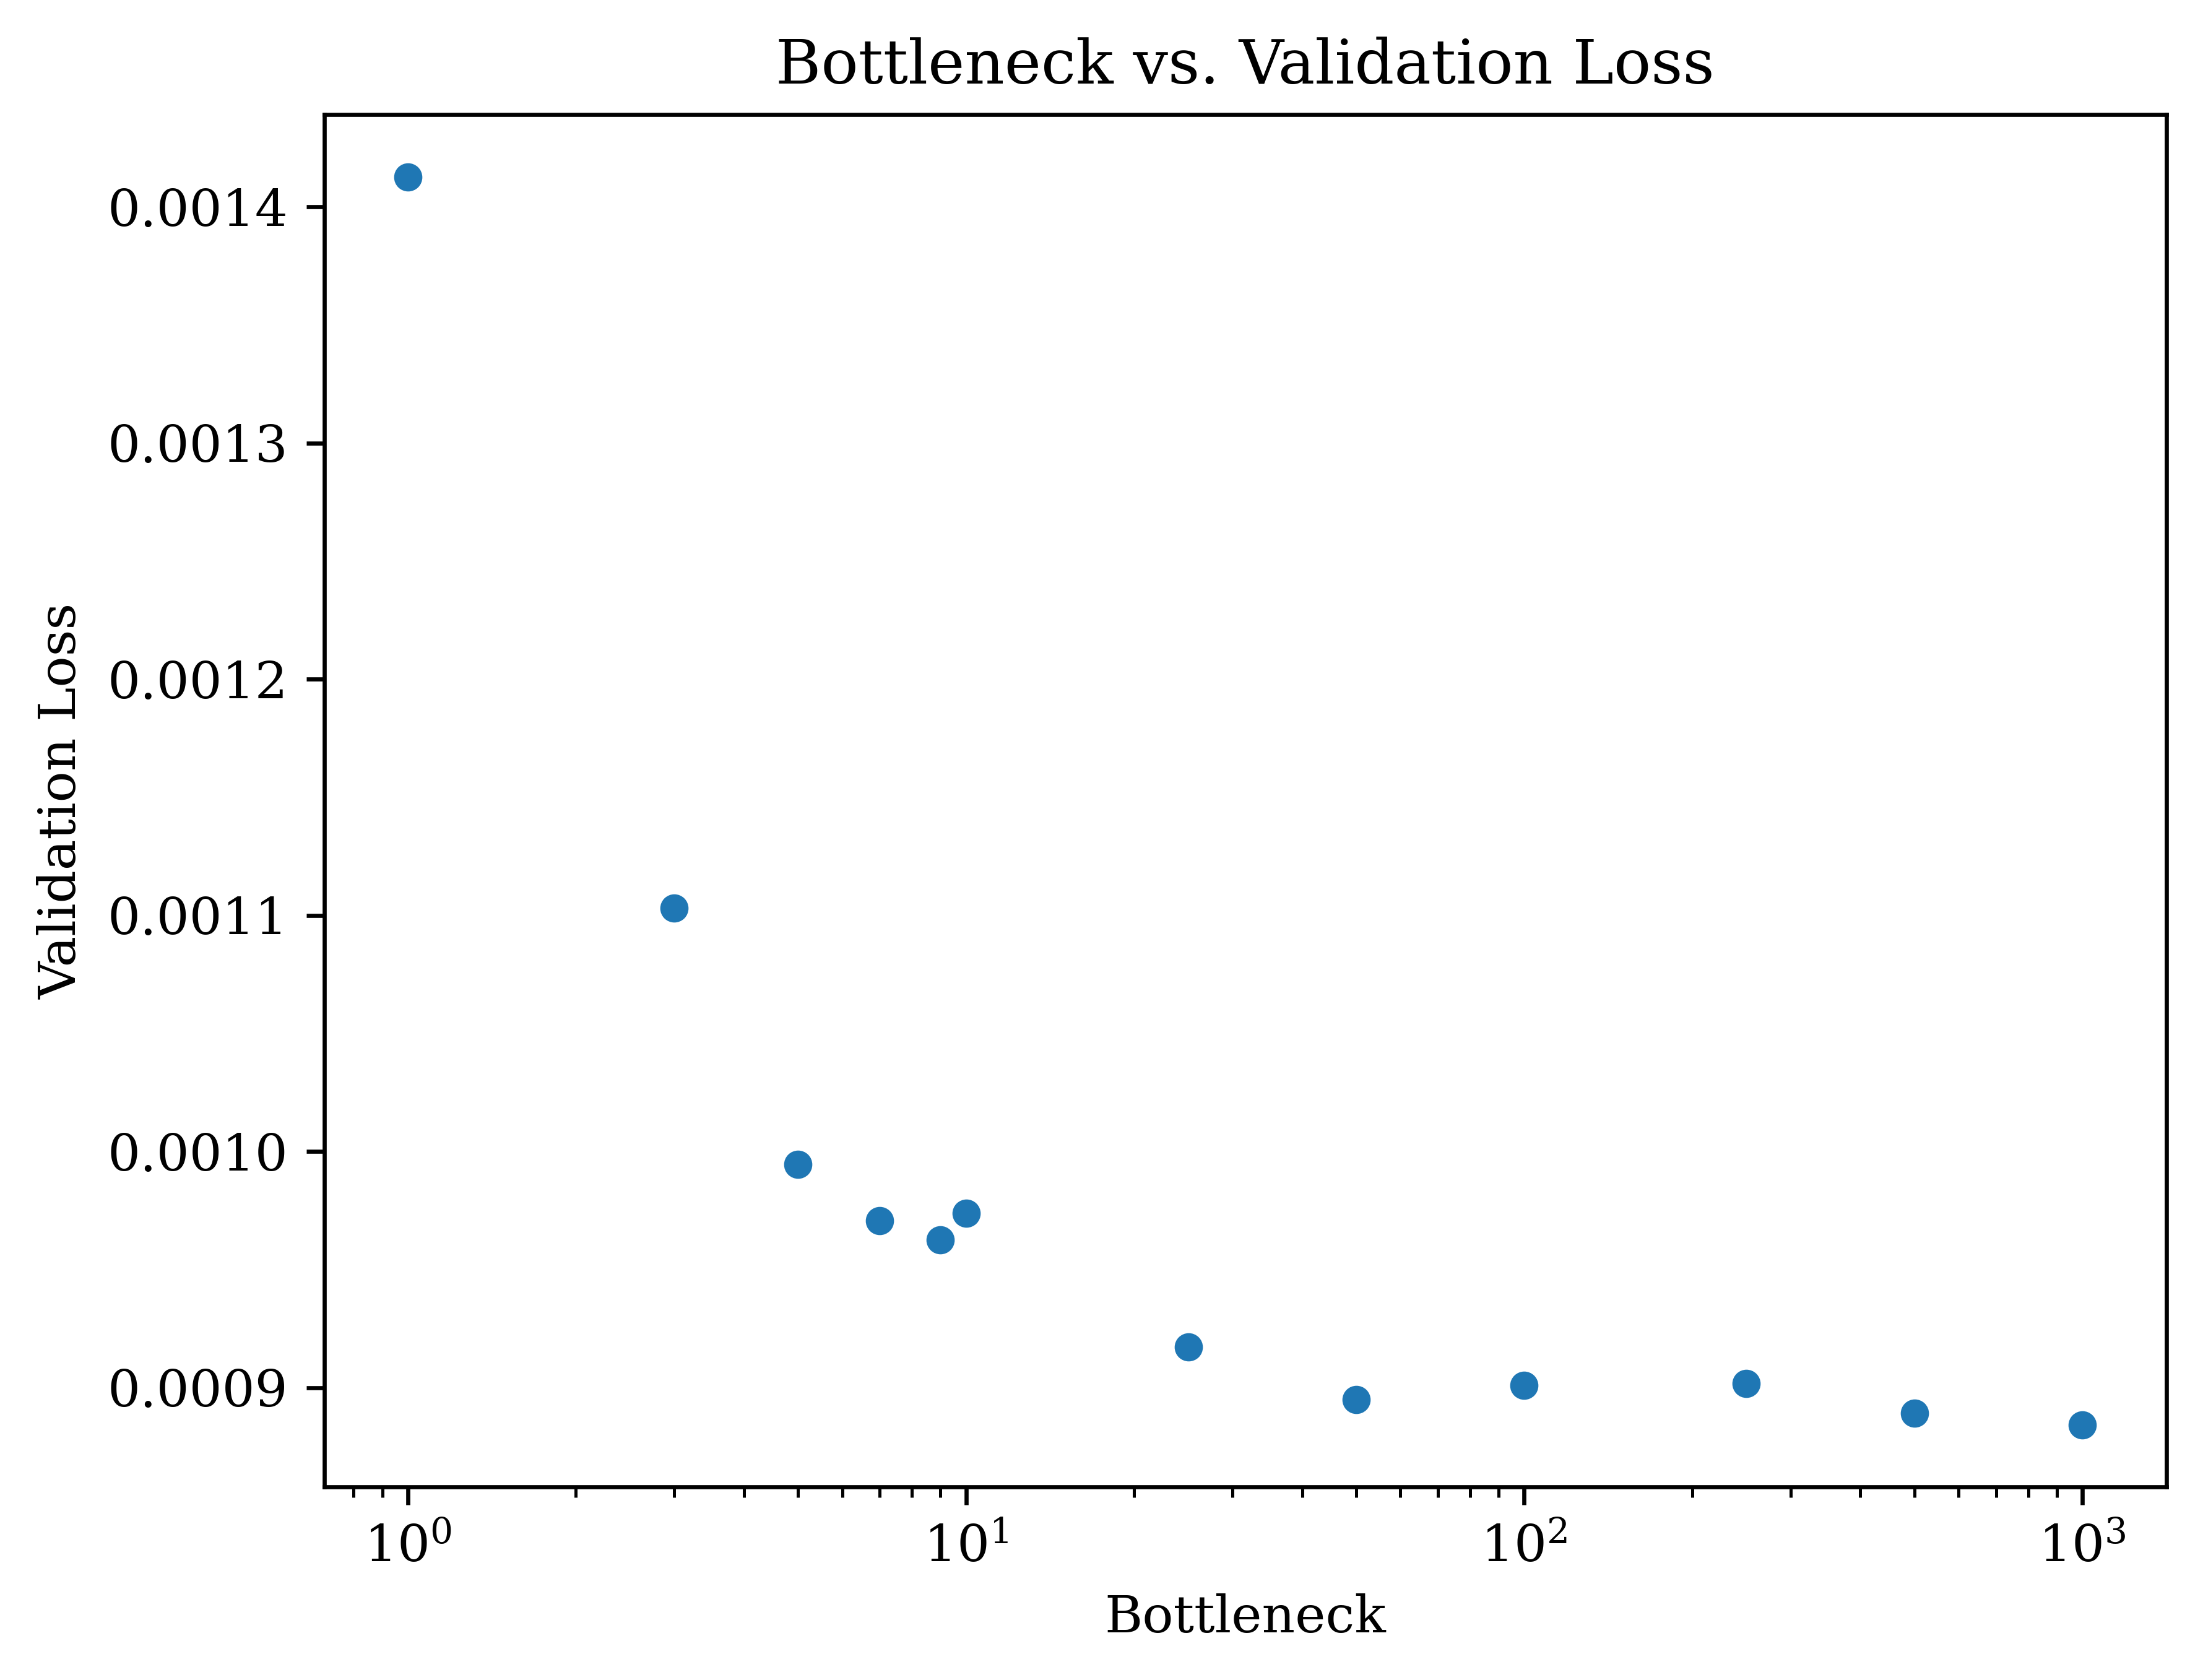

In [5]:
df.plot(
    kind="scatter",
    x="bottleneck",
    y="val_loss",
    logx=True,
    title="Bottleneck vs. Validation Loss",
    xlabel="Bottleneck size",
    ylabel="Validation Loss",
    c='k'
)

In [6]:
folder = Path("/n/groups/datta/Dana/Ontogeny/raw_data/Dana_ontogeny/Males/3months_19042021")

In [7]:
# load input data
depth_files = sorted(folder.glob("**/results_00.h5"))

frames = []
for file in depth_files[:8]:
    with h5py.File(file, 'r') as f:
        frames.append(f['frames'][()][::2])
frames = np.concatenate(frames, axis=0)

In [8]:
og_pca = PCA(n_components=25)
og_pca.fit(np.array([clean(frame) for frame in frames]).reshape(len(frames), -1))

PCA(n_components=25)

In [9]:
print(np.sum(og_pca.explained_variance_ratio_[:10]))
print(np.where(np.cumsum(og_pca.explained_variance_ratio_) > 0.9)[0][0])

0.8400718915266853
20


In [10]:
og_components = og_pca.components_[:5].reshape(-1, 80, 80)
og_components = np.concatenate(og_components, axis=1)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pca = PCA(n_components=25)
components = {}

for model_path in tqdm(files):
    model = torch.jit.load(model_path, map_location=device)
    output = predict(Session(frames), model, batch_size=1024, desc="Predicting")
    pca.fit(output.reshape(len(output), -1))

    # variance explained in 10 components
    var_exp = np.sum(pca.explained_variance_ratio_[:10])
    # number of components to explain 90% of variance
    n_pcs = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.9)[0][0]
    df.loc[model_path, 'var_exp'] = var_exp
    df.loc[model_path, 'n_pcs'] = n_pcs
    comps = np.concatenate(pca.components_[:5].reshape(-1, 80, 80), axis=1)
    components[model_path] = comps

  0%|          | 0/12 [00:00<?, ?it/s]

Predicting:   0%|          | 0/211 [00:00<?, ?it/s]

Predicting:   0%|          | 0/211 [00:00<?, ?it/s]

Predicting:   0%|          | 0/211 [00:00<?, ?it/s]

Predicting:   0%|          | 0/211 [00:00<?, ?it/s]

Predicting:   0%|          | 0/211 [00:00<?, ?it/s]

Predicting:   0%|          | 0/211 [00:00<?, ?it/s]

Predicting:   0%|          | 0/211 [00:00<?, ?it/s]

Predicting:   0%|          | 0/211 [00:00<?, ?it/s]

Predicting:   0%|          | 0/211 [00:00<?, ?it/s]

Predicting:   0%|          | 0/211 [00:00<?, ?it/s]

Predicting:   0%|          | 0/211 [00:00<?, ?it/s]

Predicting:   0%|          | 0/211 [00:00<?, ?it/s]

<Axes: xlabel='bottleneck', ylabel='var_exp'>

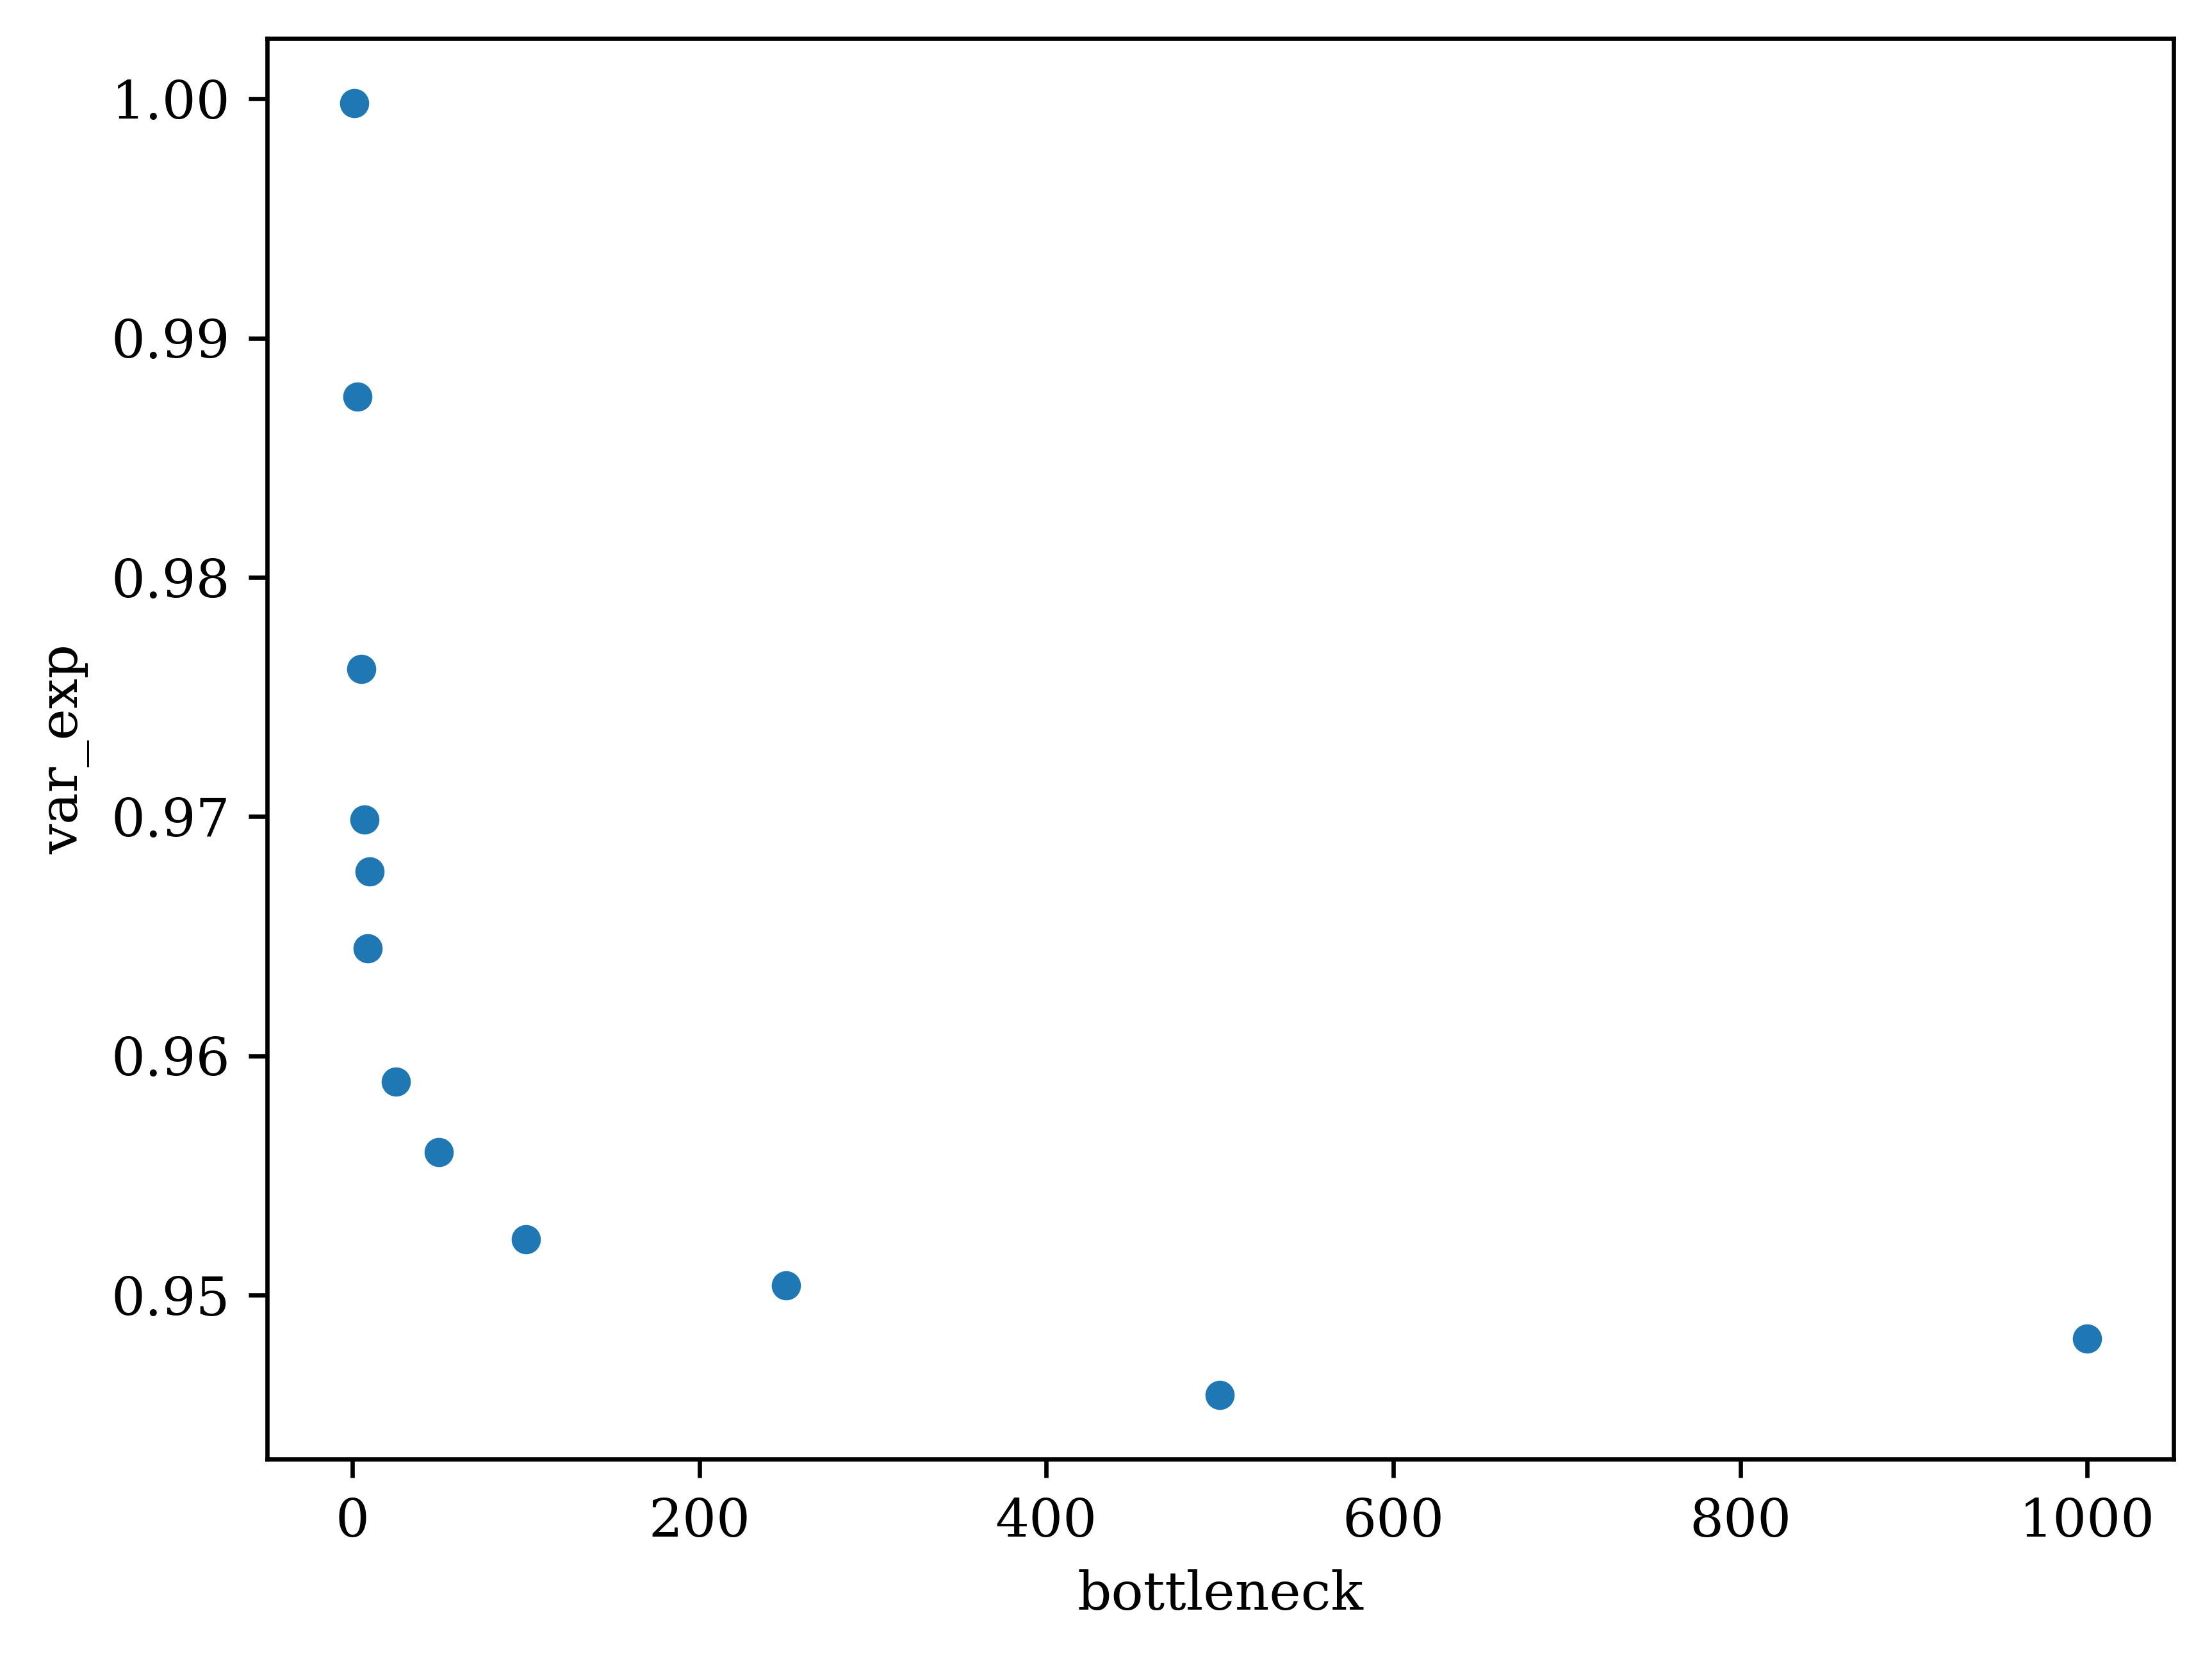

In [12]:
df.plot(kind='scatter', x='bottleneck', y='var_exp')

<Axes: xlabel='bottleneck', ylabel='n_pcs'>

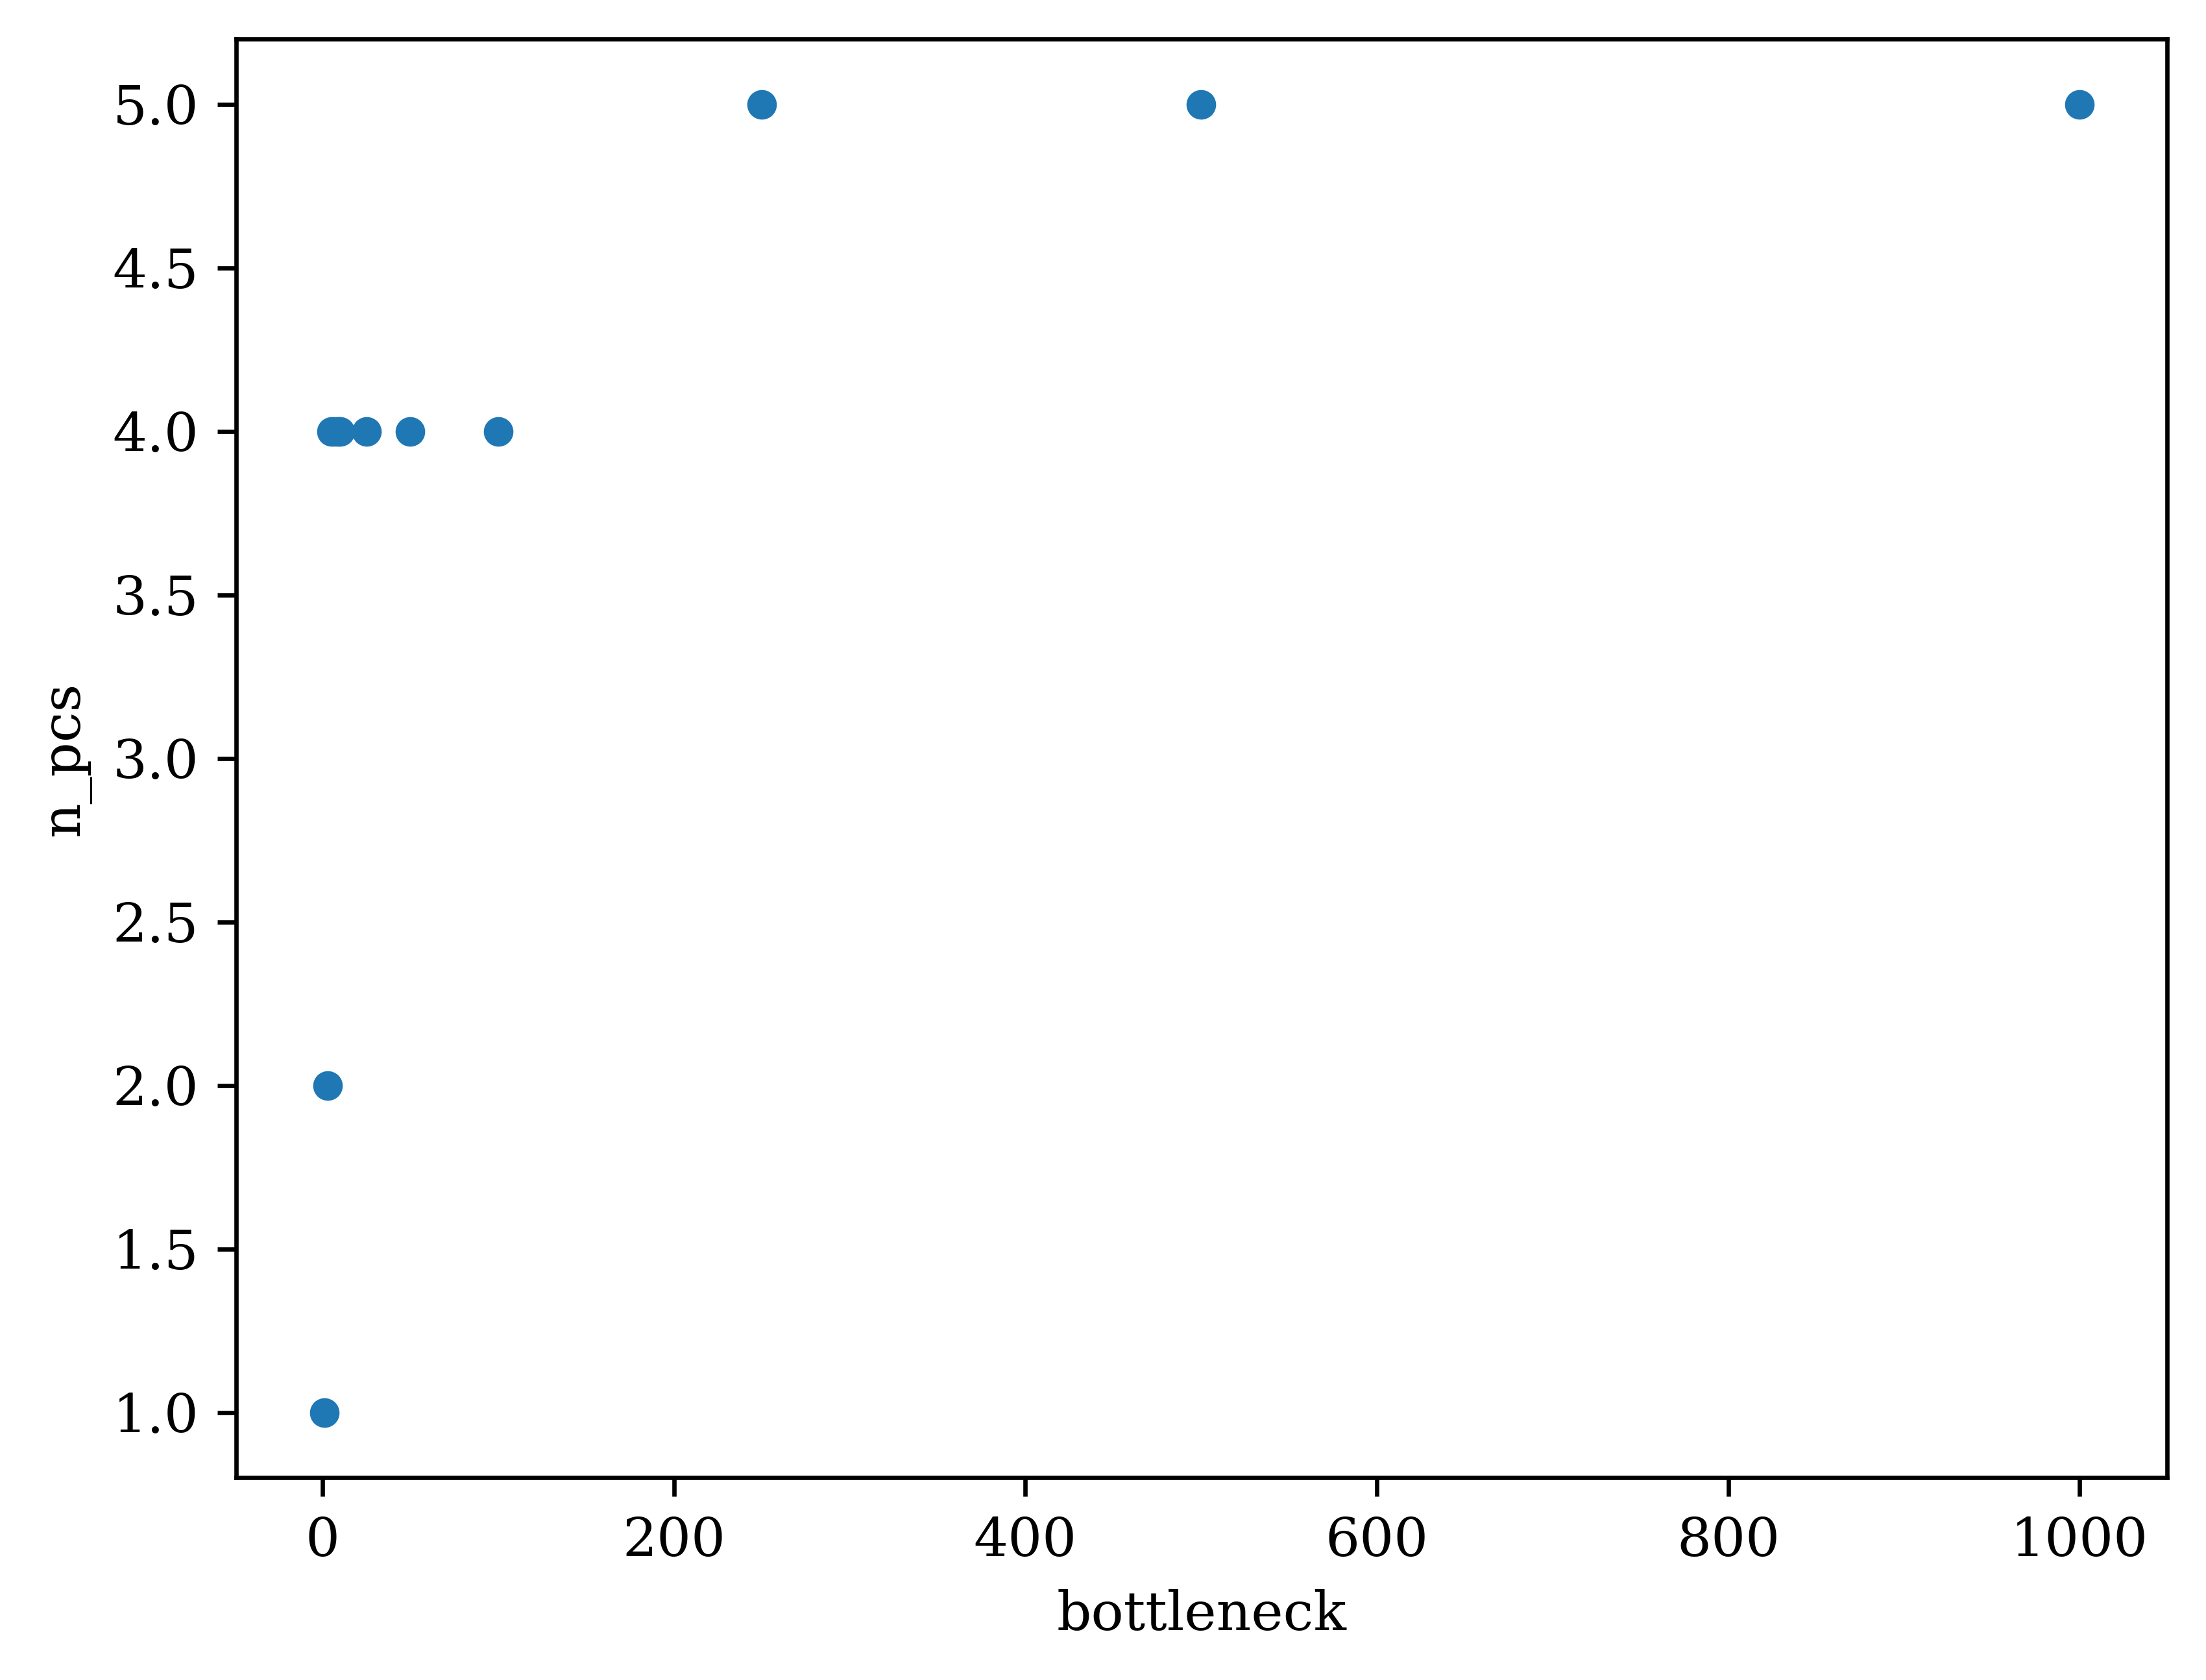

In [13]:
df.plot(kind='scatter', x='bottleneck', y='n_pcs')

In [14]:
sorted_df = df.sort_values(by='bottleneck')

Text(0.5, 1.0, 'Original')

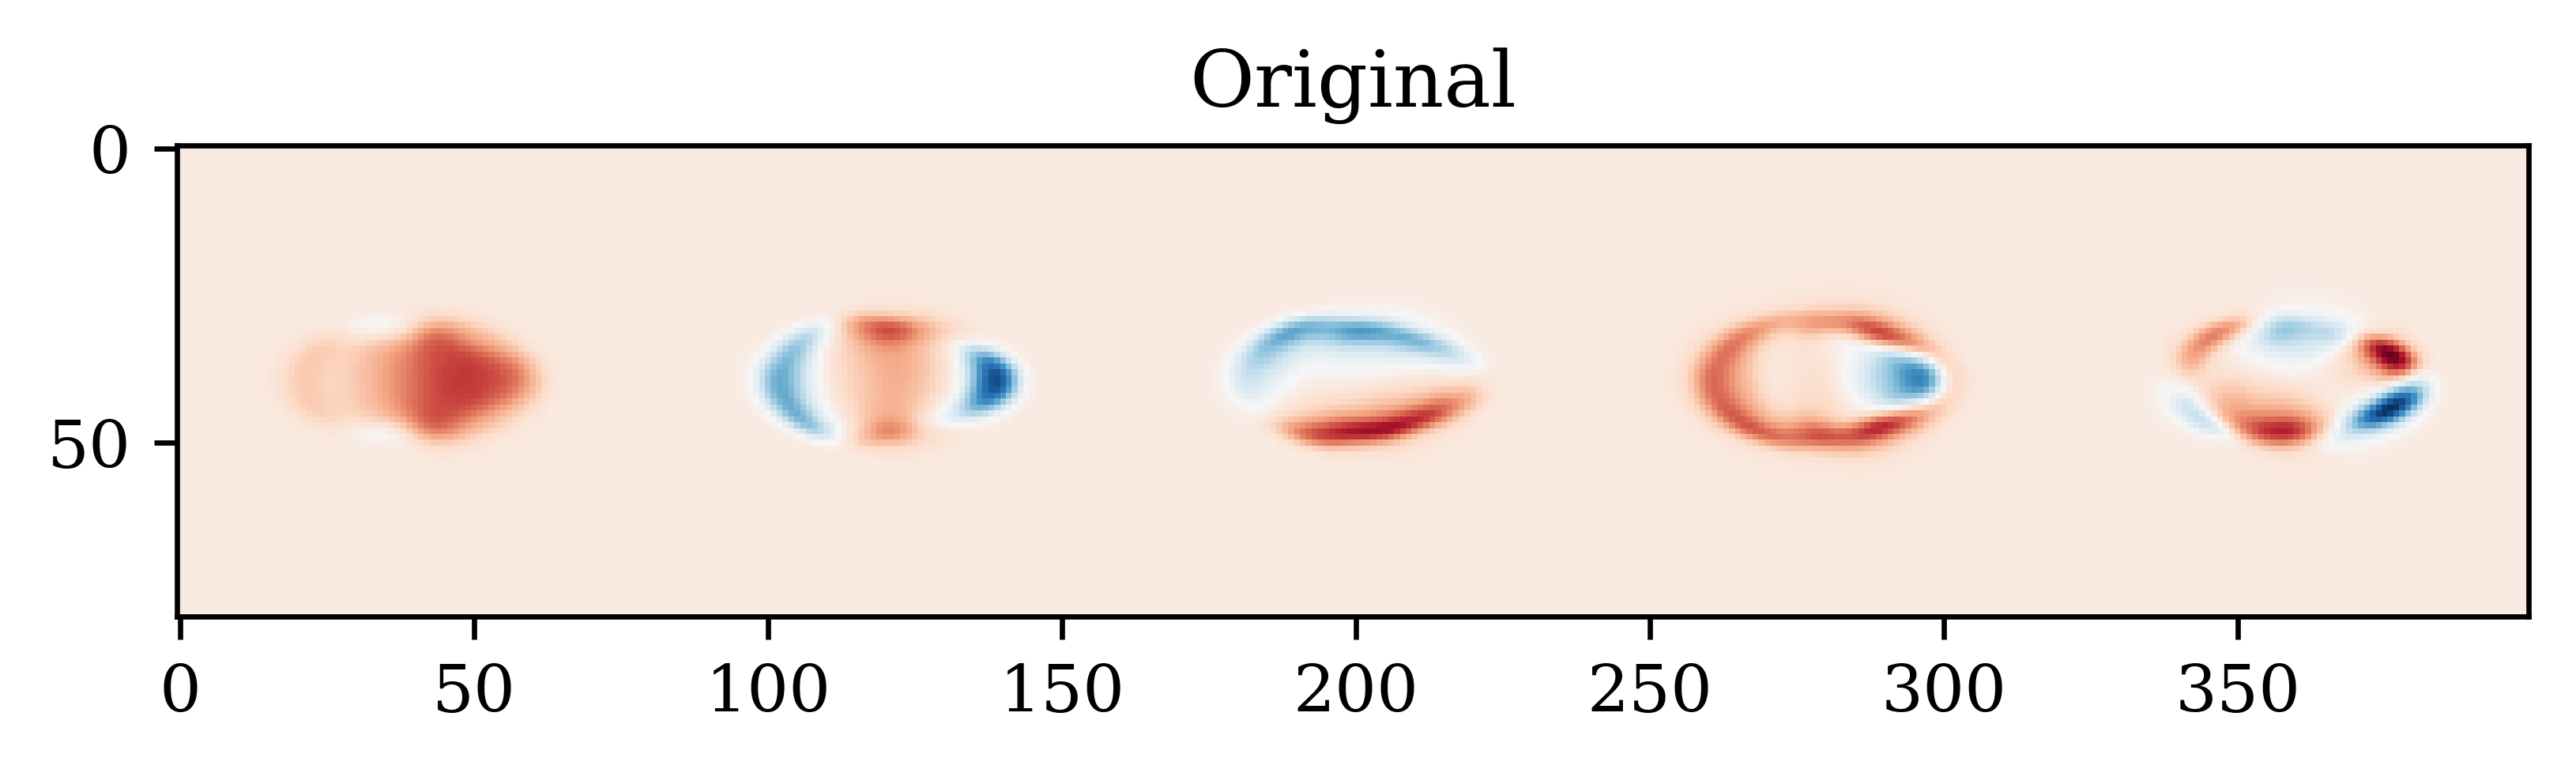

In [17]:
plt.imshow(og_components, cmap='RdBu_r', )
plt.title("Original")

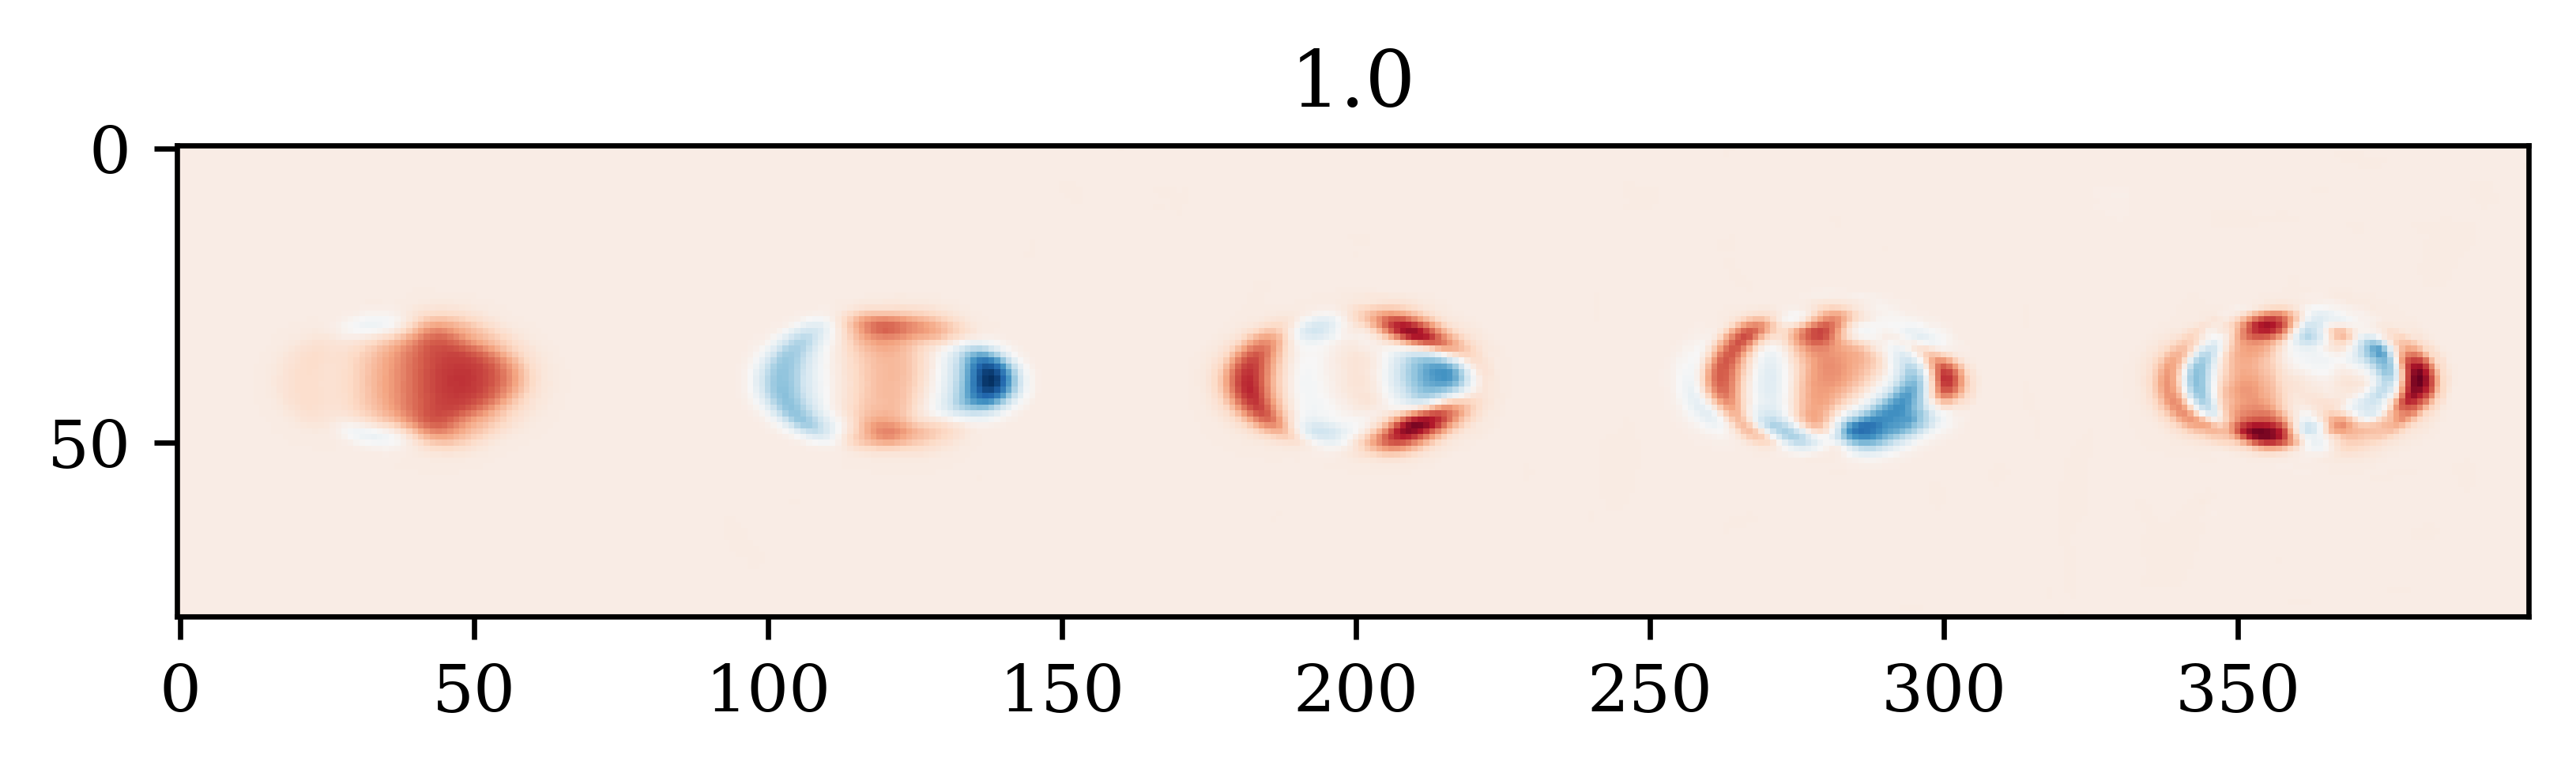

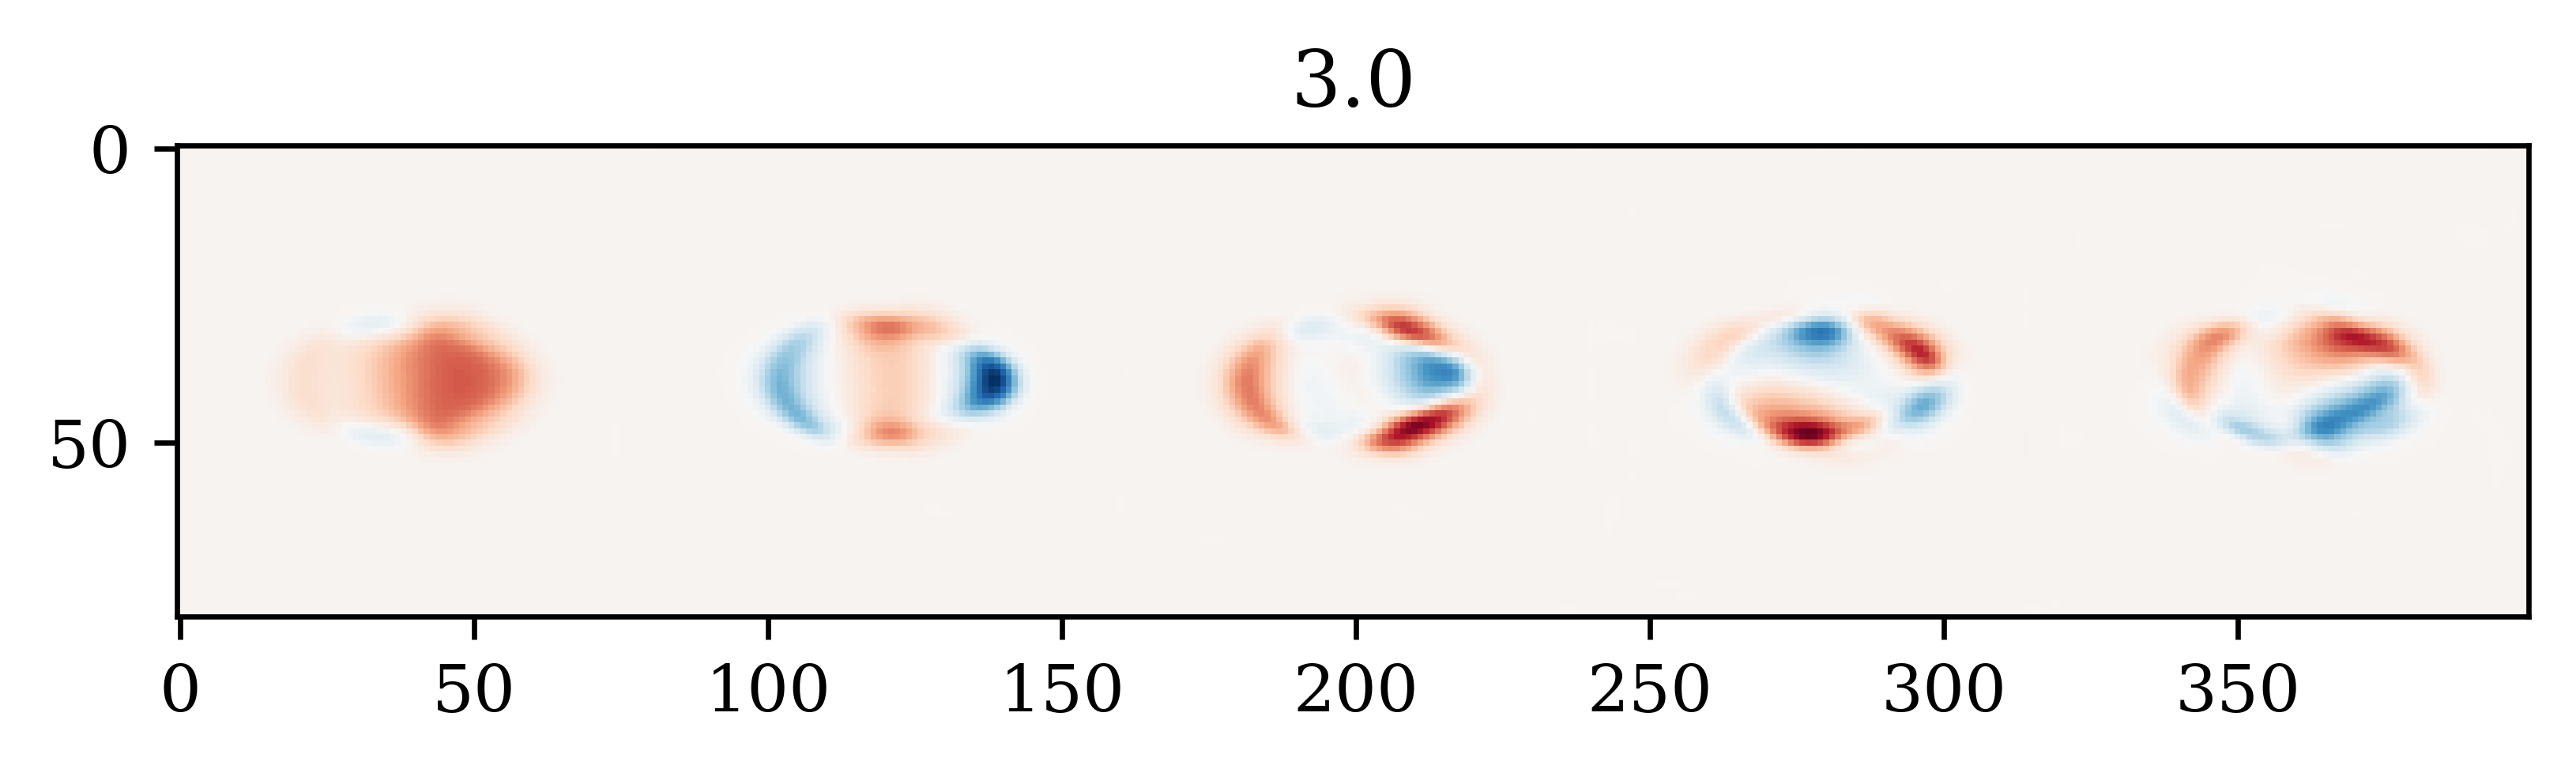

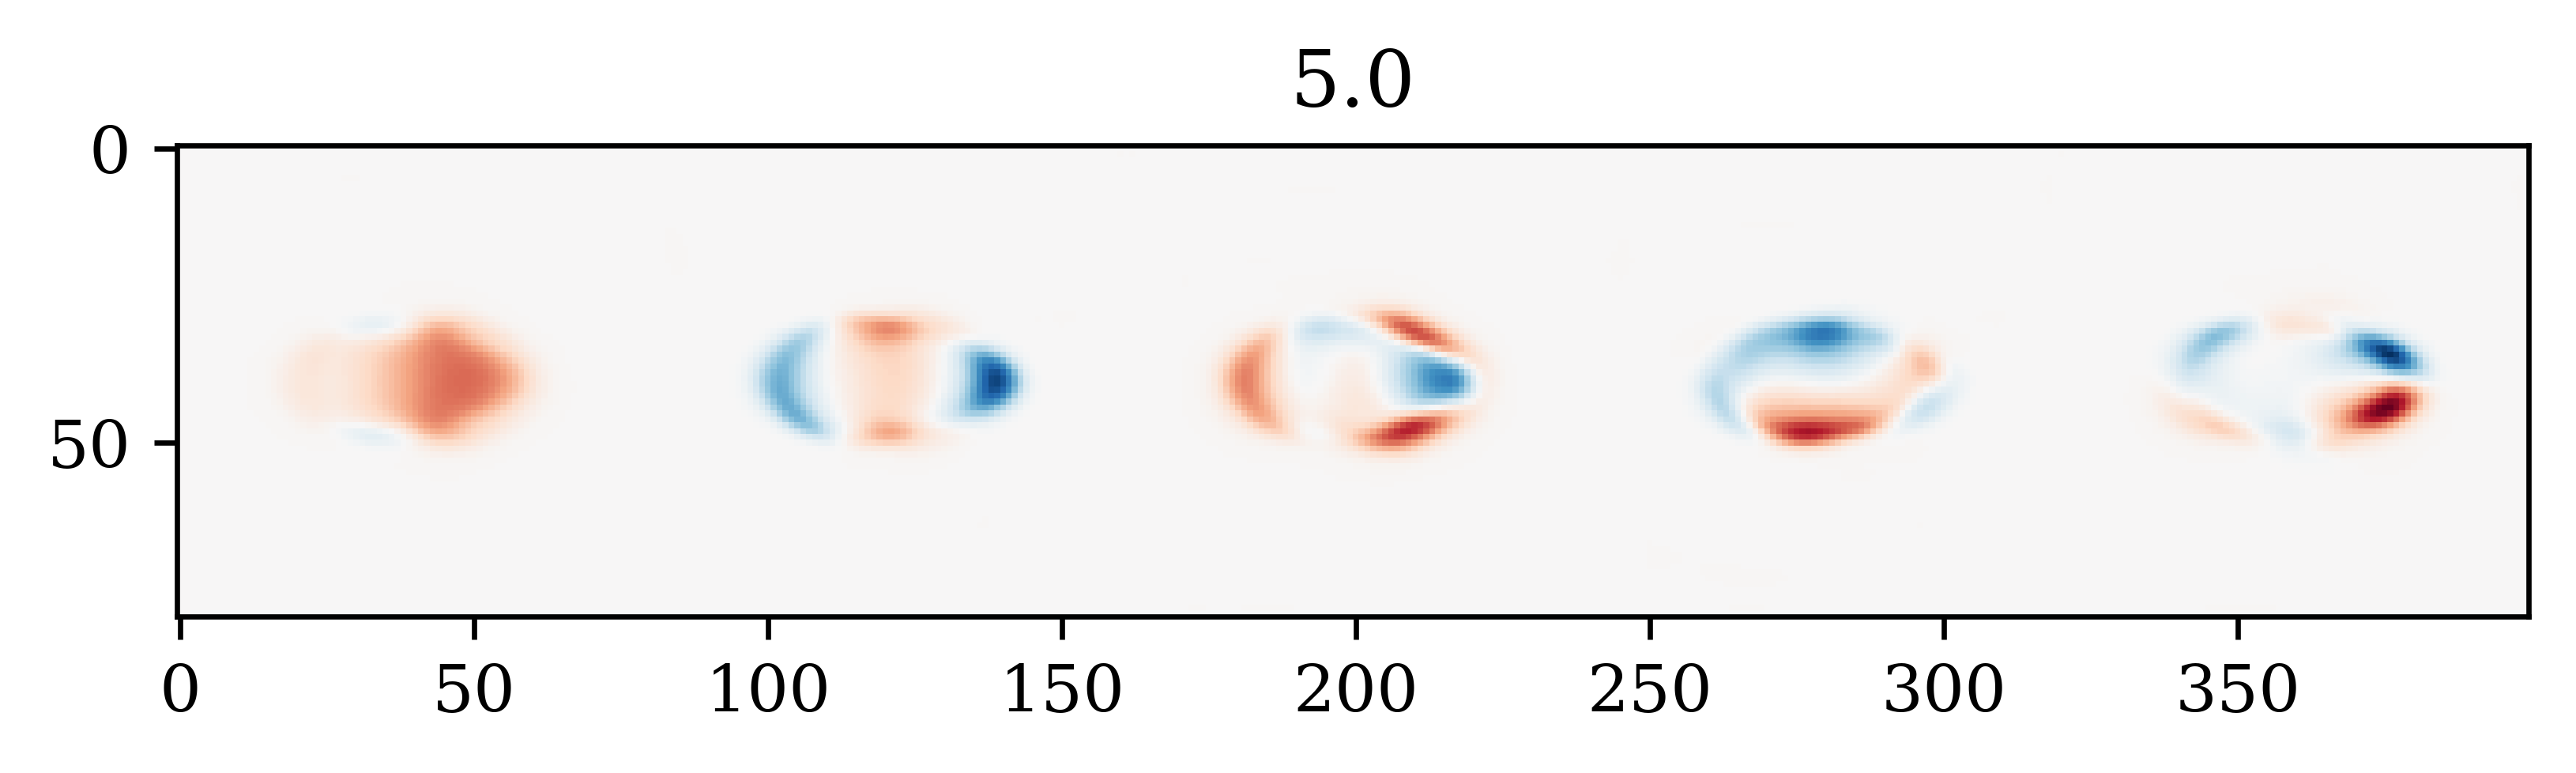

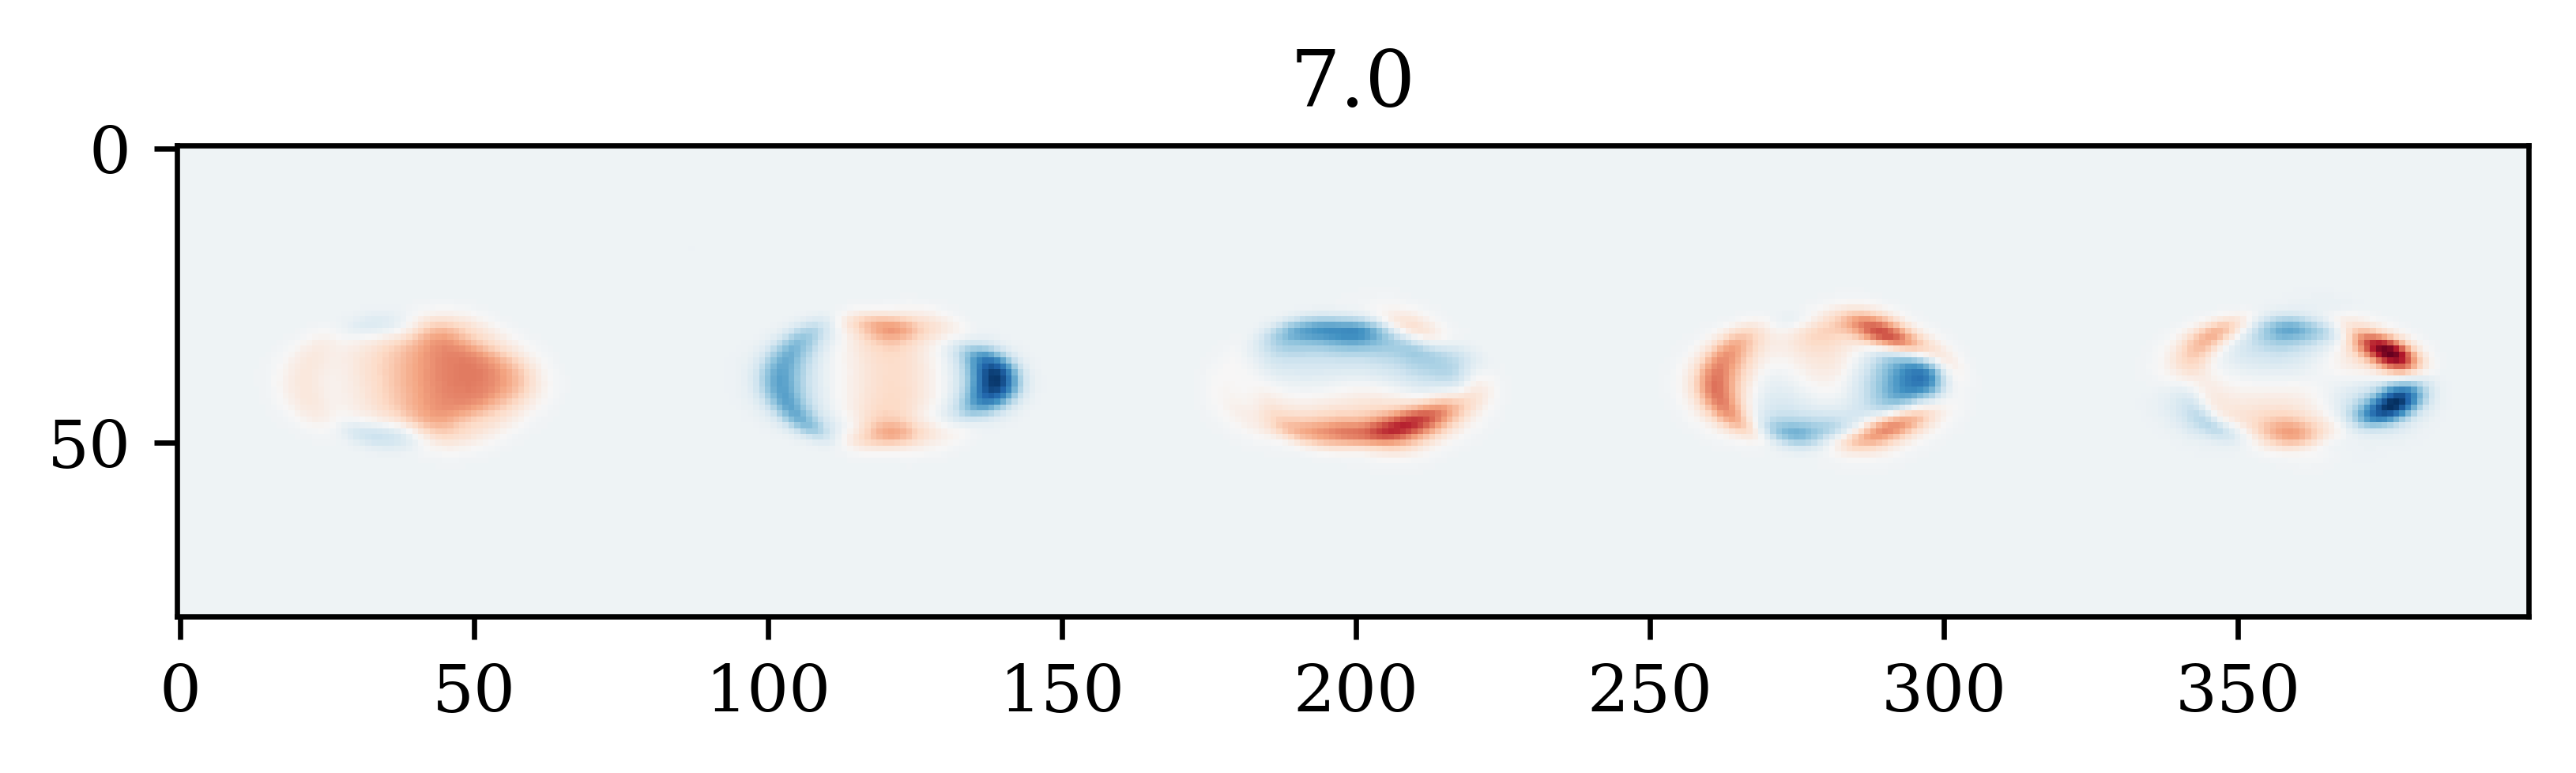

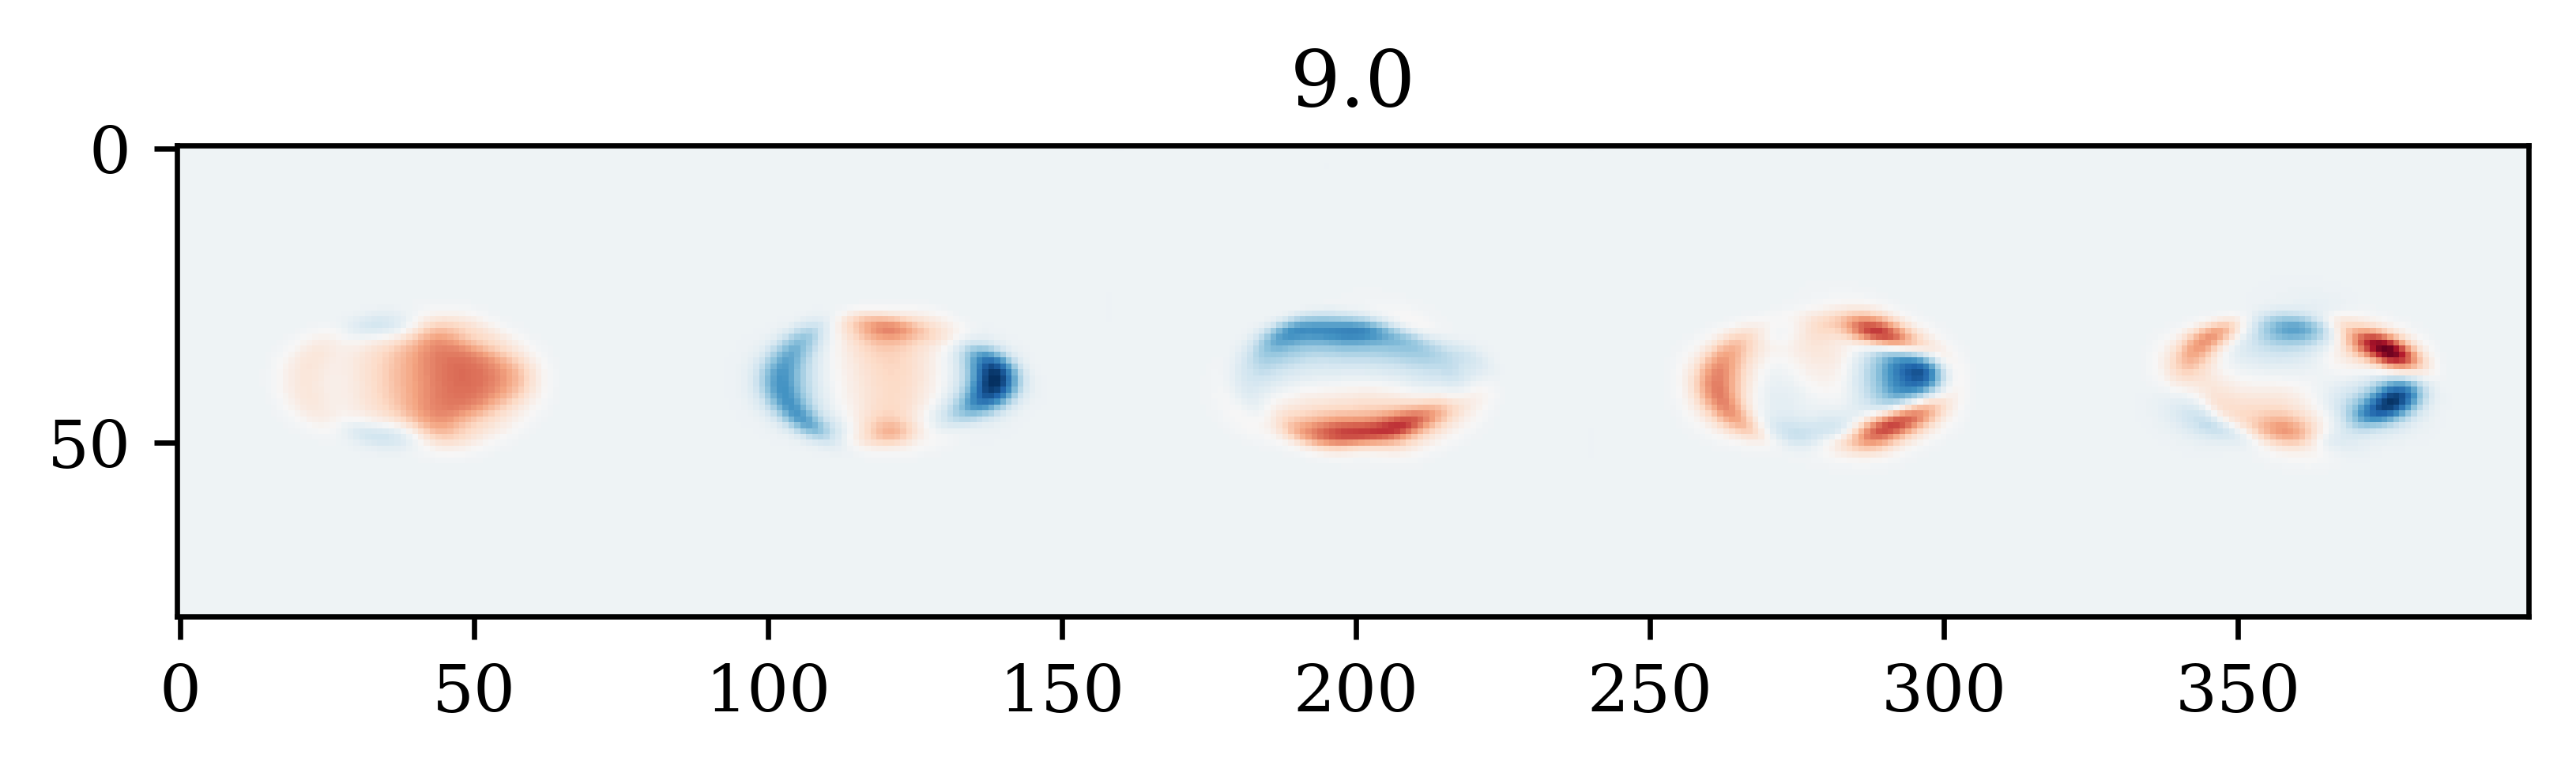

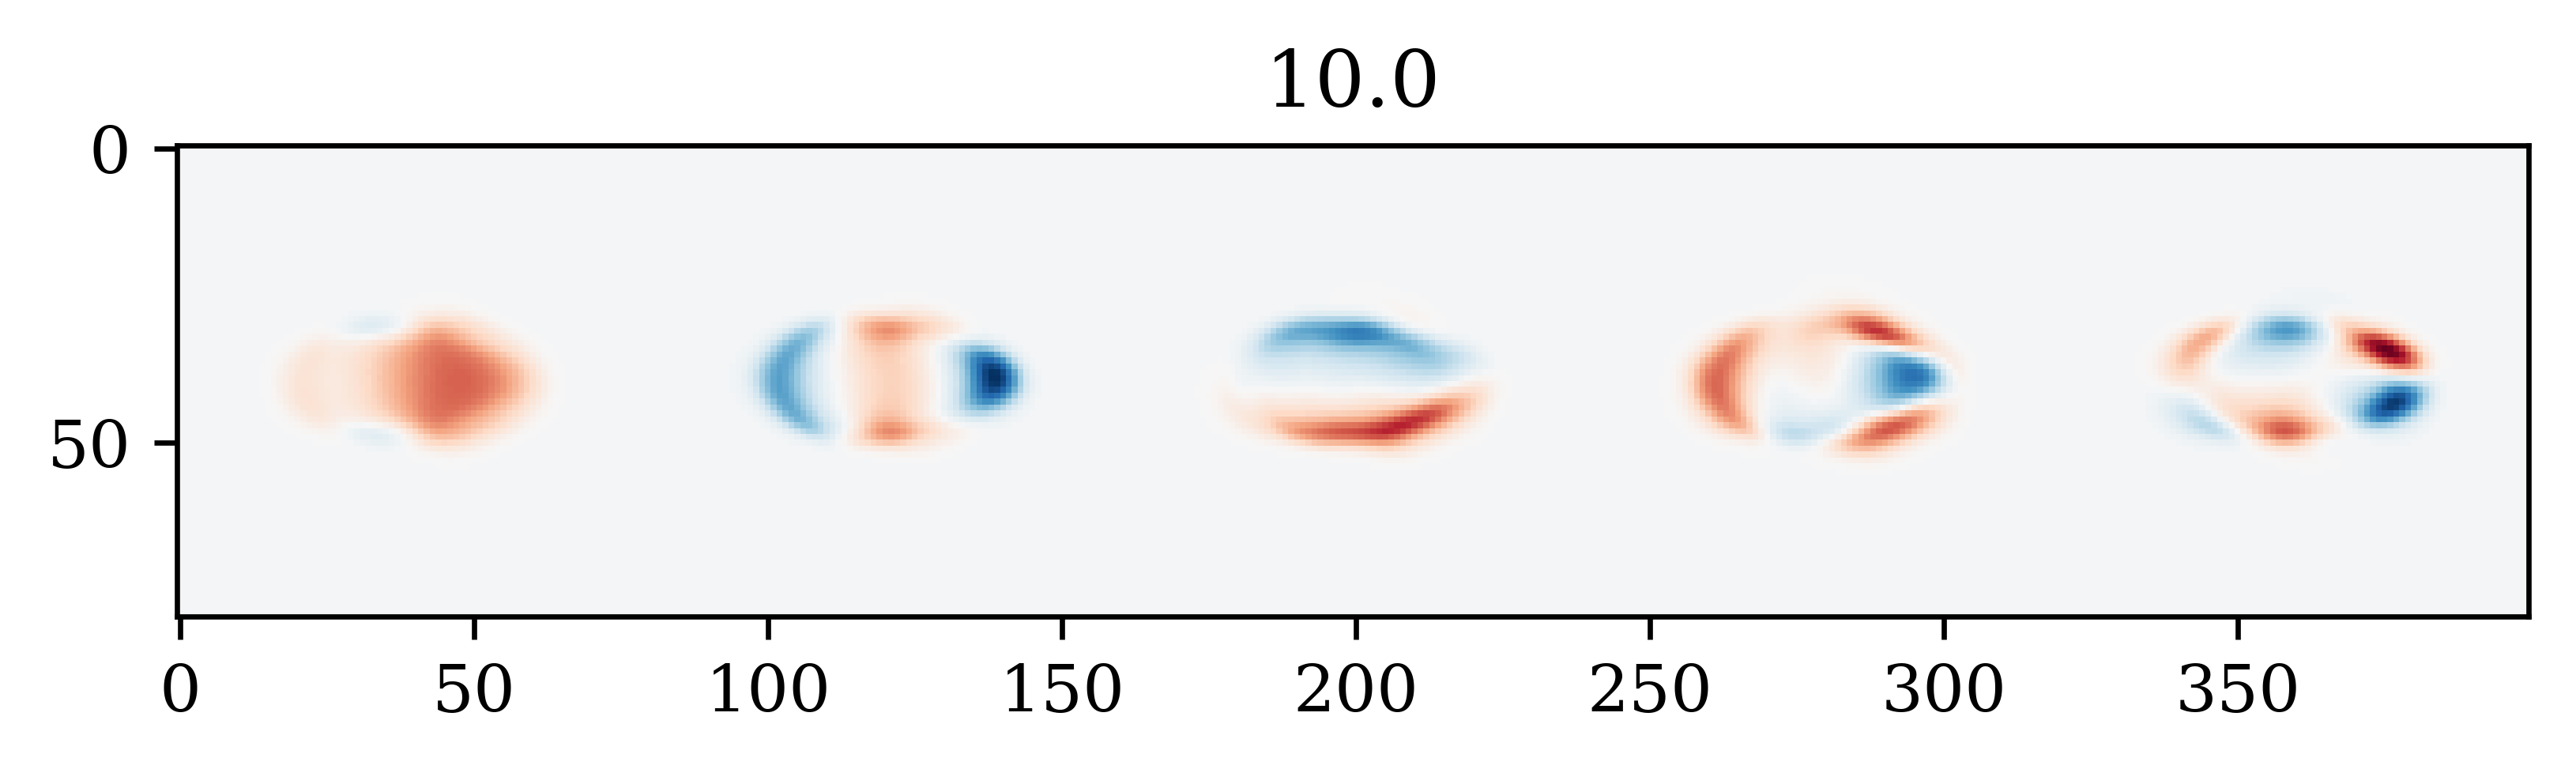

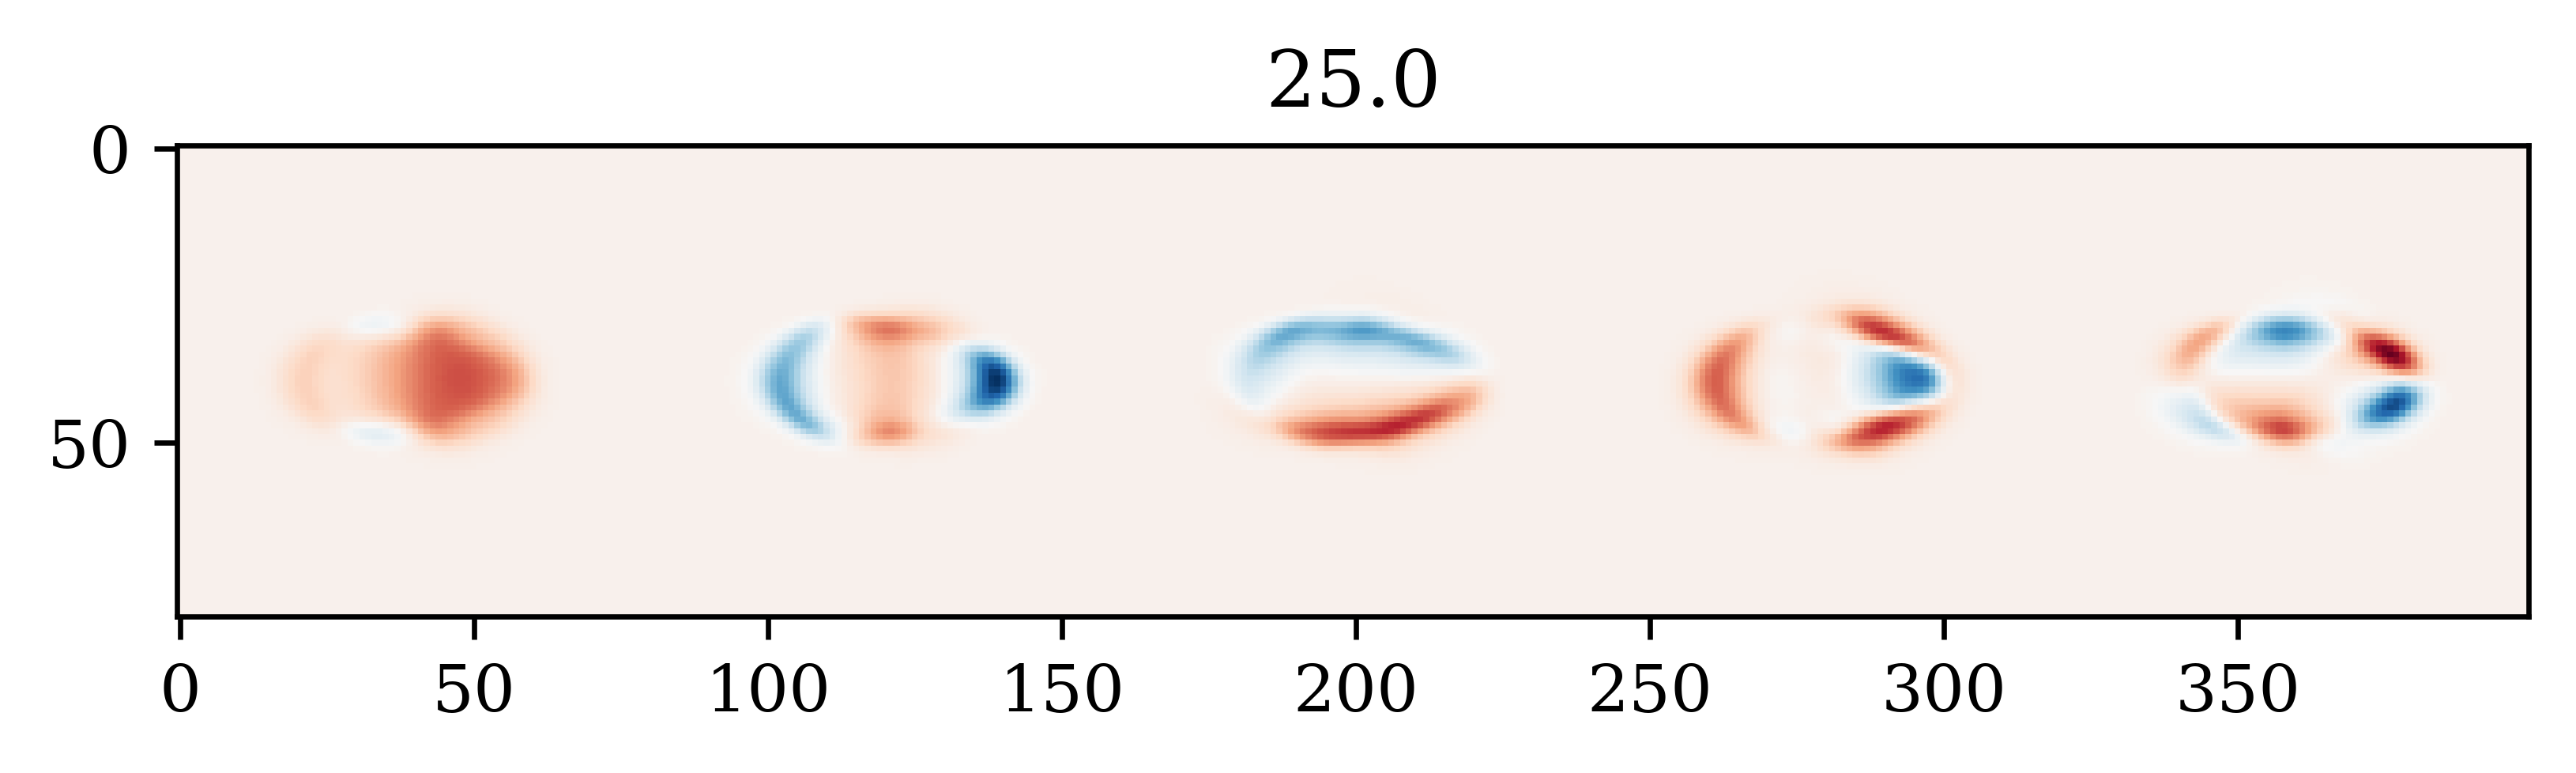

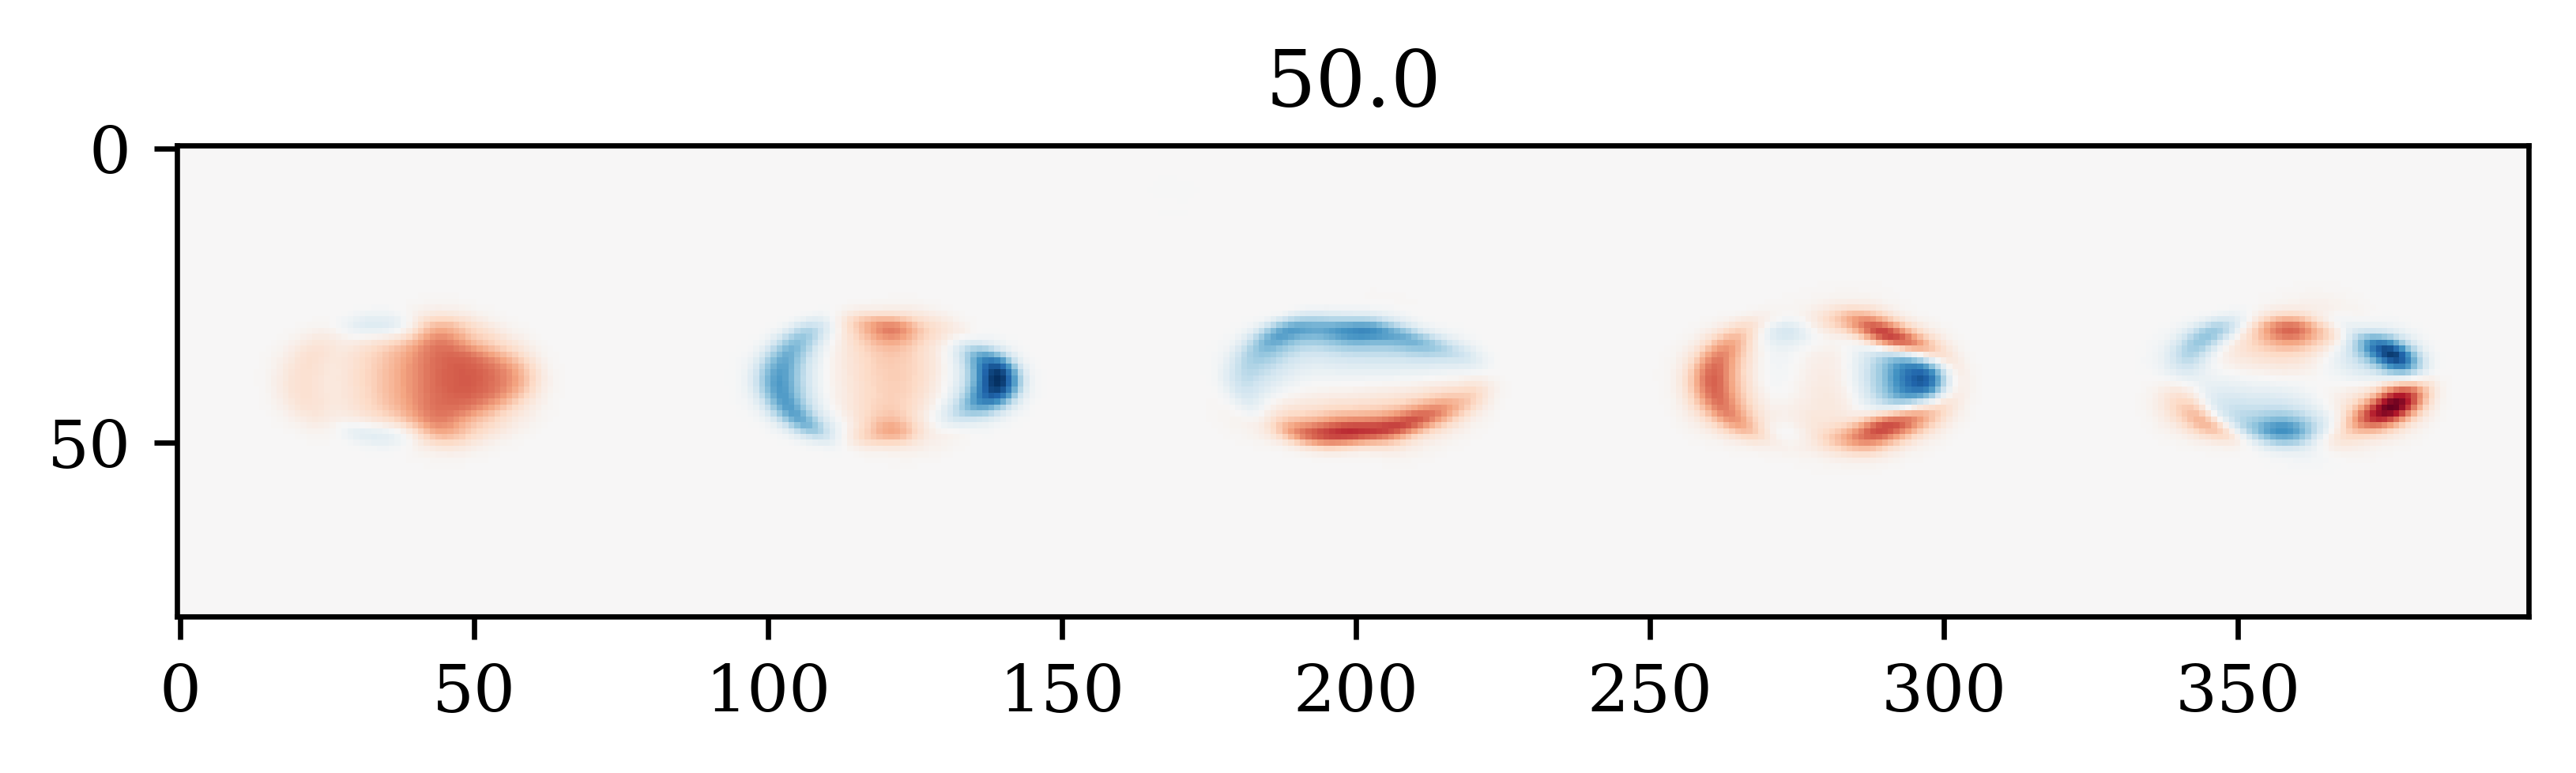

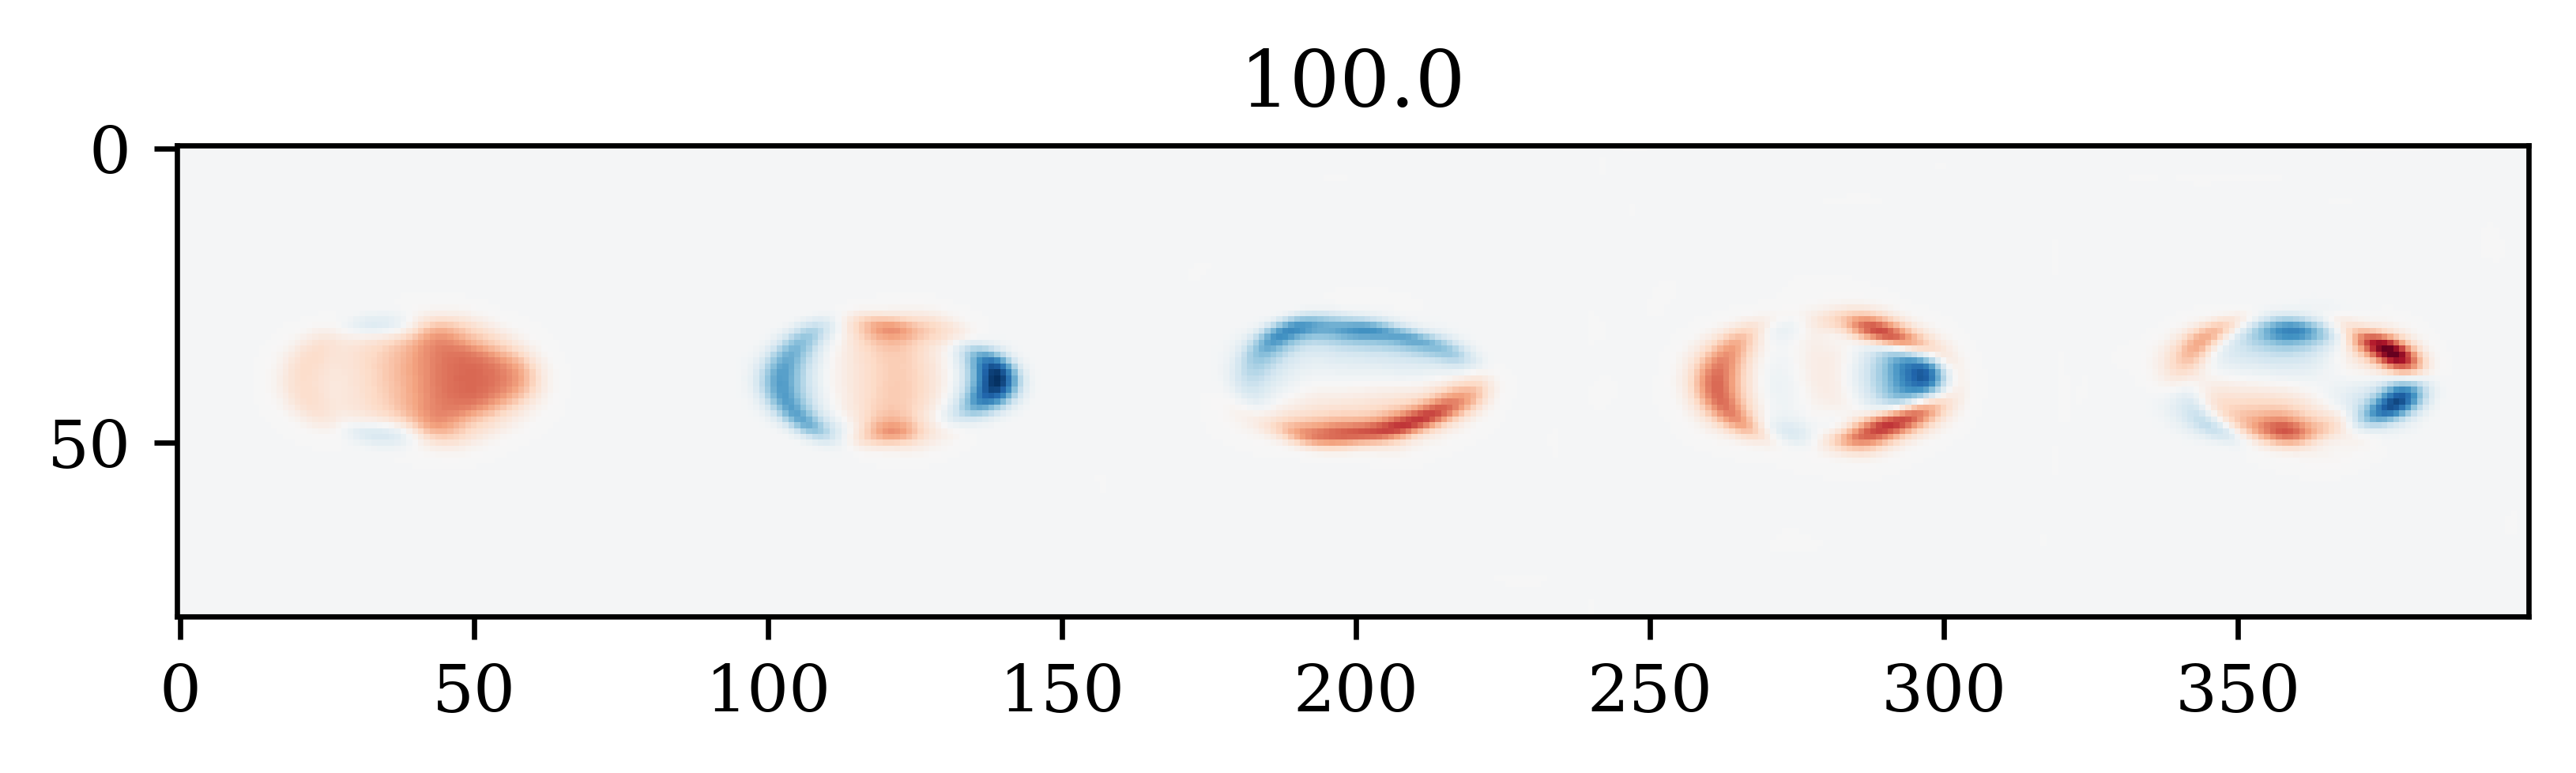

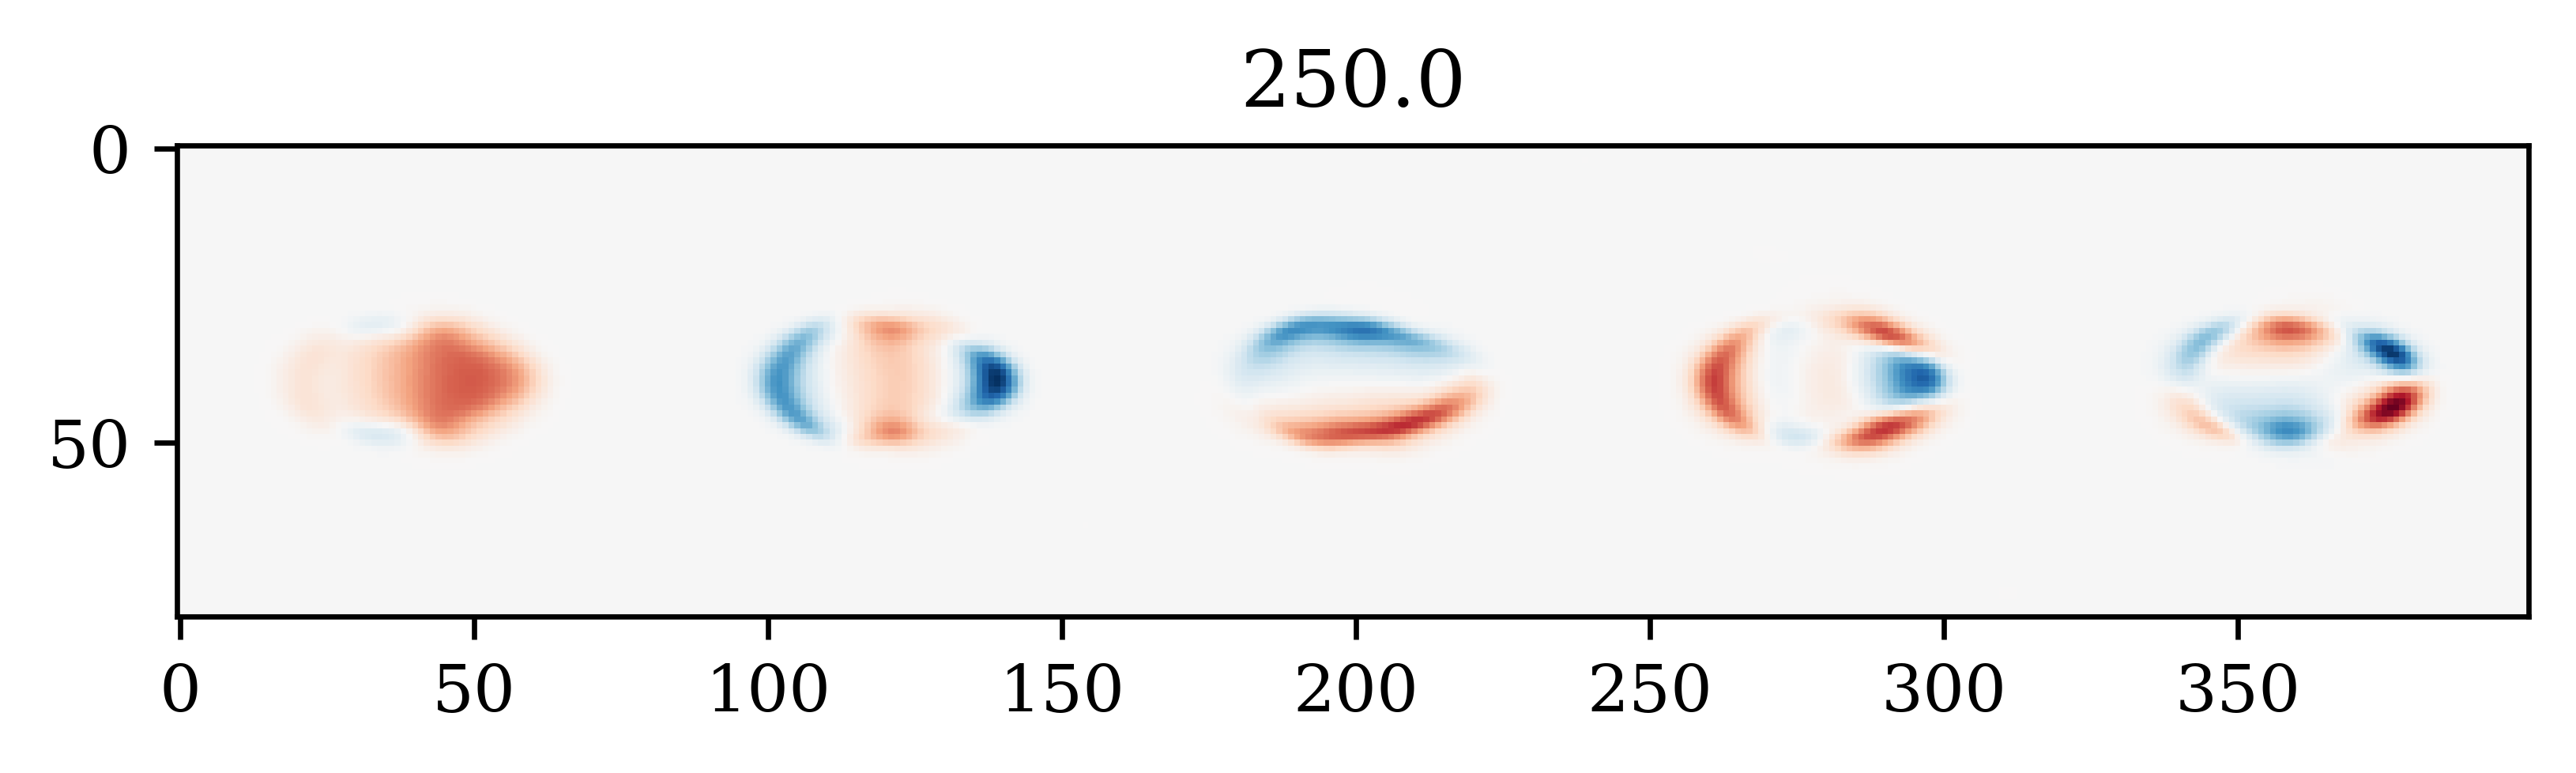

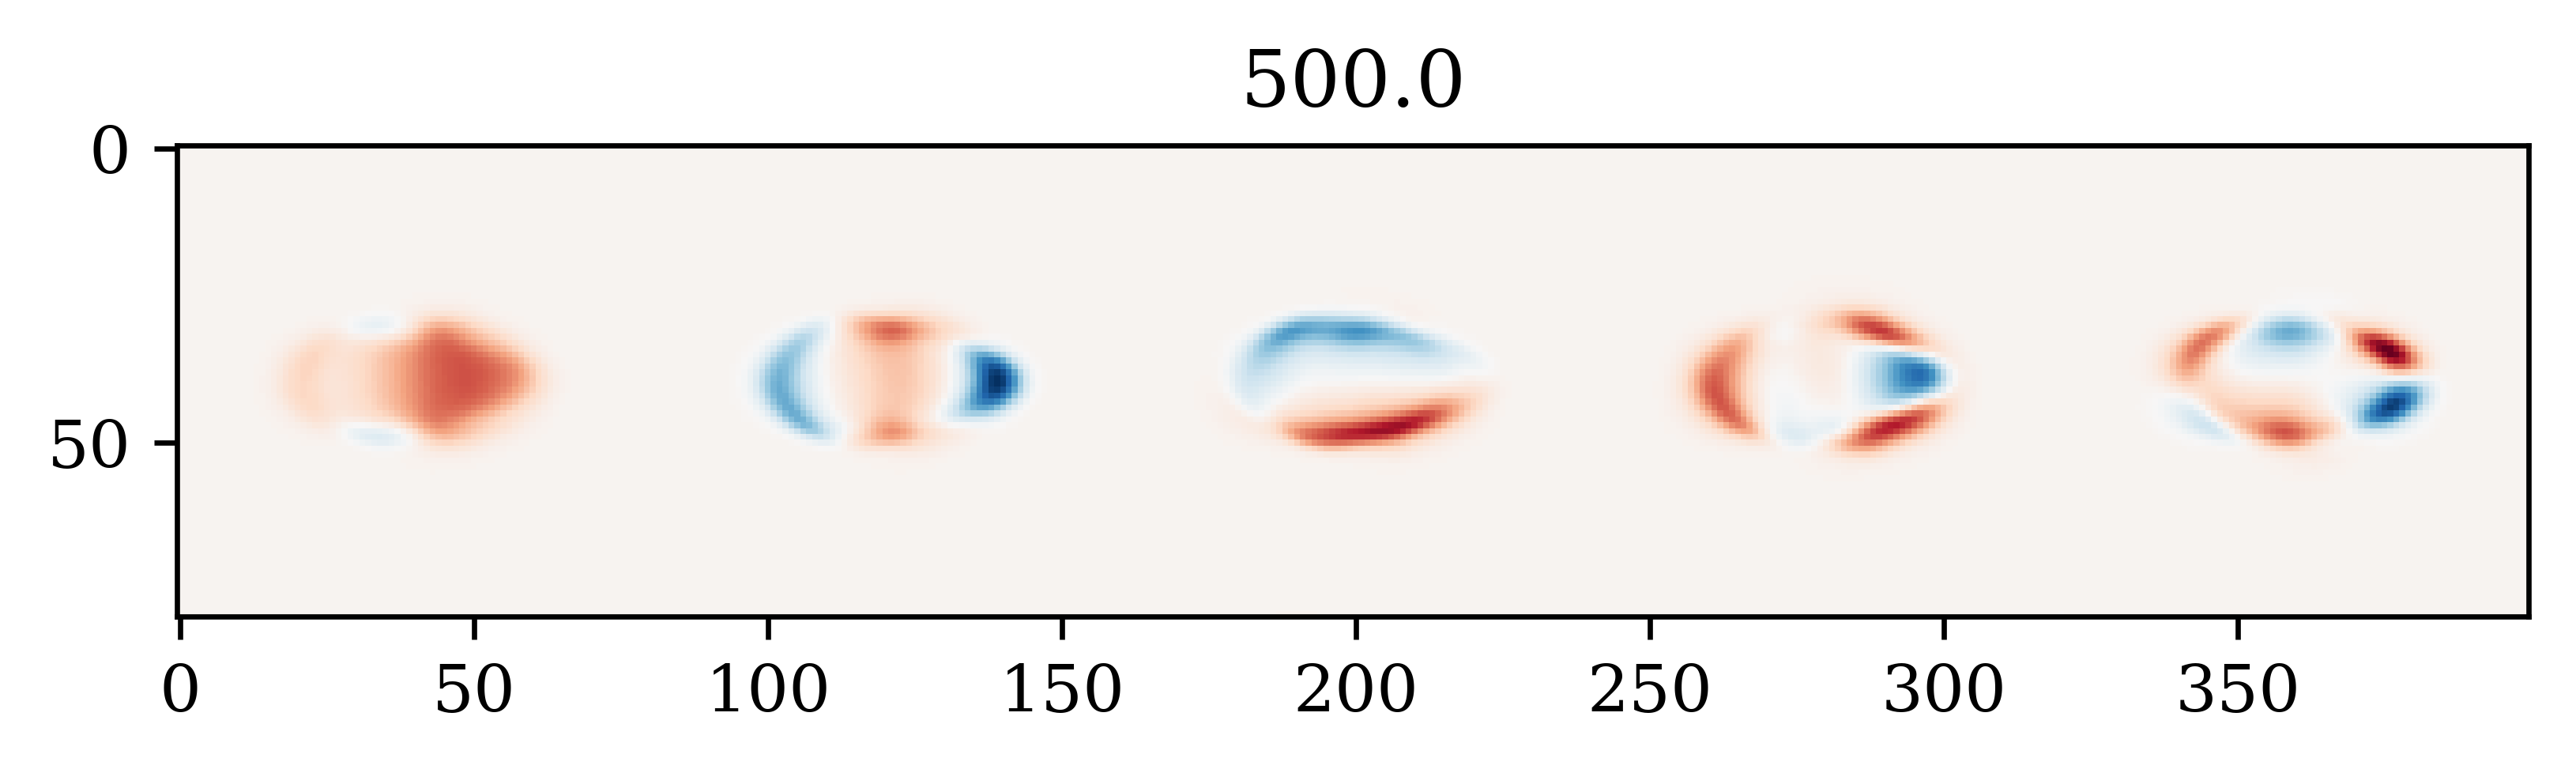

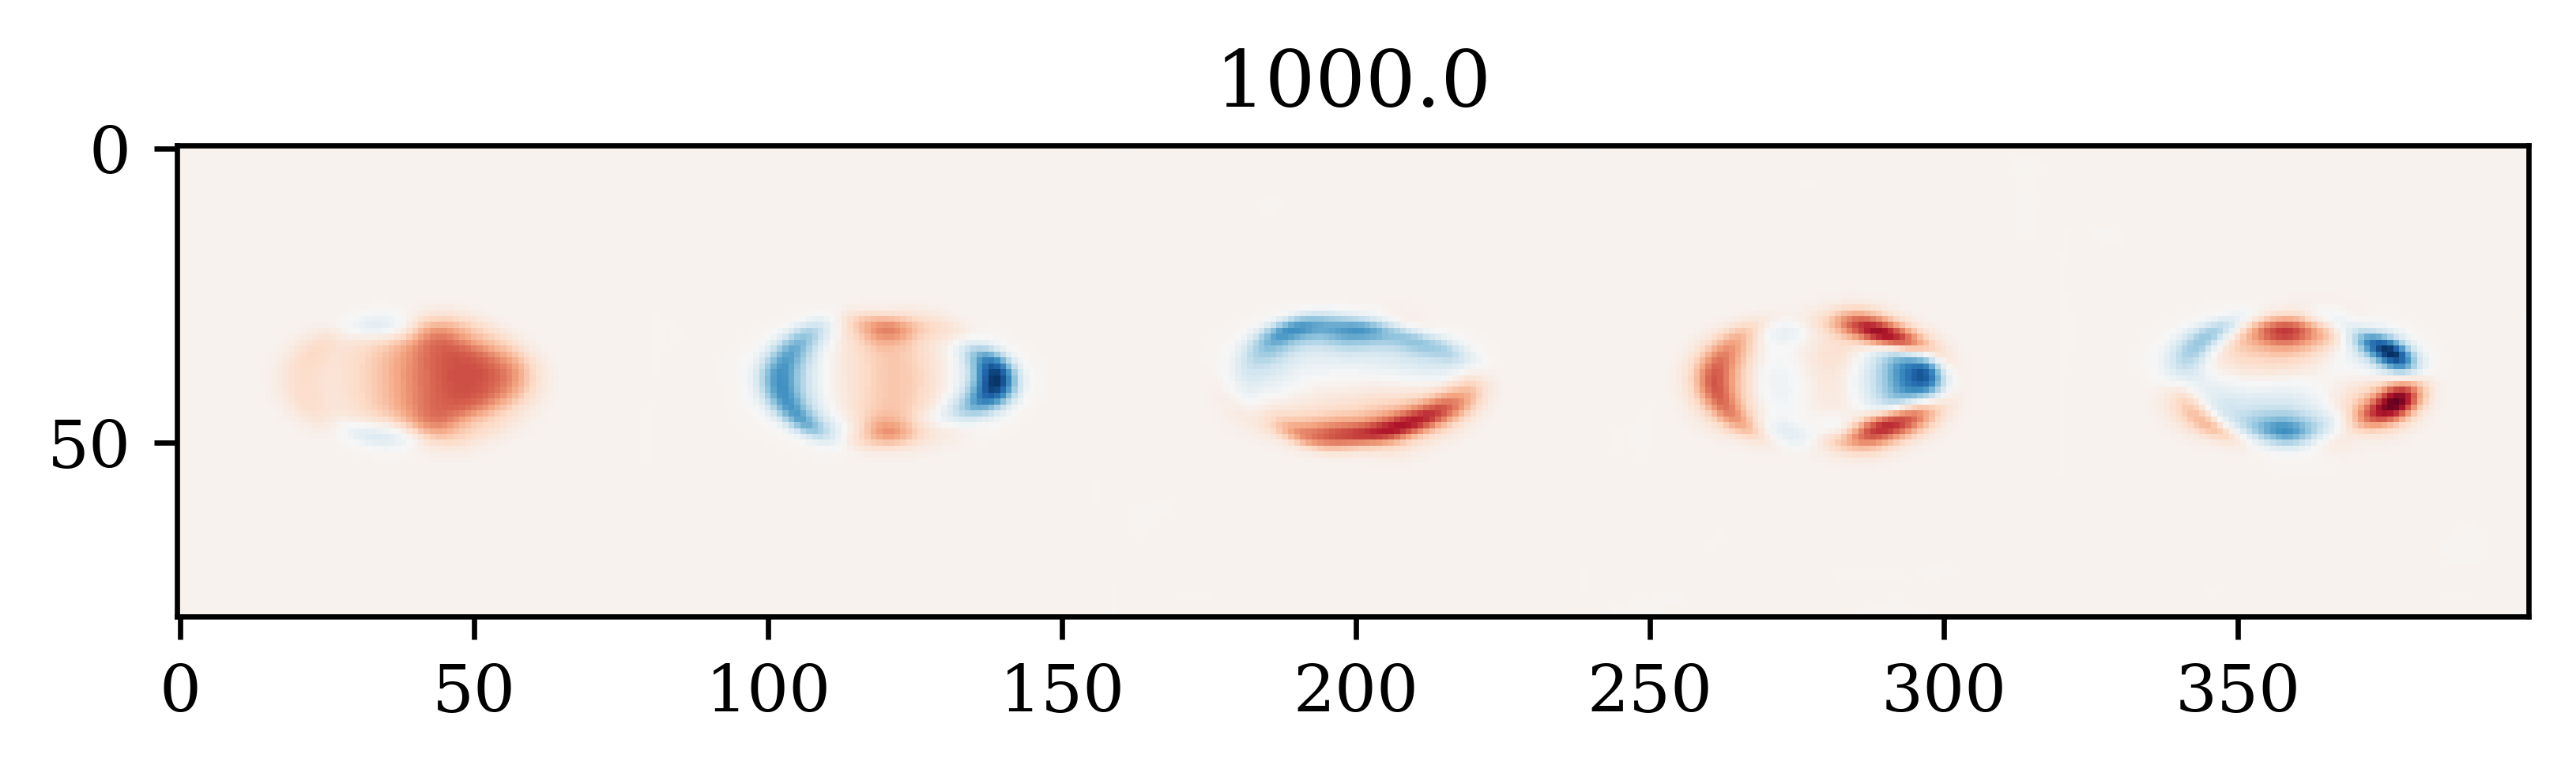

In [16]:
for i in range(len(sorted_df)):
    plt.figure()
    plt.imshow(components[sorted_df.index[i]], cmap='RdBu_r', )
    plt.title(sorted_df.iloc[i].bottleneck)